# Определение перспективного тарифа для телеком-компании


**Автор:**  
Григорьев Павел


**Описание проекта:**

Коммерческий департамент компании «Мегалайн», федерального оператора сотовой связи, стремится оптимизировать рекламный бюджет, выяснив, какой из тарифных планов - «Смарт» или «Ультра» - приносит больше дохода. Для этого необходимо провести предварительный анализ на основе данных 500 пользователей, включая информацию о тарифах, количестве звонков и сообщений за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод - какой тариф лучше.

**Цель:**  

Провести анализ данных 500 пользователей компании «Мегалайн» для определения более прибыльного тарифного плана («Смарт» или «Ультра») и оптимизации рекламного бюджета.

**Источники данных:**  

Данные о пользователях и тарифных планах предоставлены компанией «Мегалайн».

**Условия проведения анализа днных:**  

Для анализ будут использоваться данные с 1 января 2018 по 31 декабря 2018 года

## Загрузка библиотек <skip>

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import plotly.express as px
import pagri_data_tools  # type: ignore
pd.set_option('display.max_columns', None)

## Описание и изучение данных


### Описание данных


Описание тарифов

- Тариф «Смарт»

    - Ежемесячная плата: 550 рублей
    - Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
    - Стоимость услуг сверх тарифного пакета: 1. минута разговора: 3 рубля («Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута); 2. сообщение: 3 рубля; 3. 1 Гб интернет-трафика: 200 рублей.

- Тариф «Ультра»

    - Ежемесячная плата: 1950 рублей
    - Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
    - Стоимость услуг сверх тарифного пакета: 1. минута разговора: 1 рубль; 2. сообщение: 1 рубль; 3. 1 Гб интернет-трафика: 150 рублей.


**Таблица users (информация о пользователях):**


- user_id - уникальный идентификатор пользователя
- first_name - имя пользователя
- last_name - фамилия пользователя
- age - возраст пользователя (годы)
- reg_date - дата подключения тарифа (день, месяц, год)
- churn_date - дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- city - город проживания пользователя
- tarif - название тарифного плана

**Таблица calls (информация о звонках):**

- id - уникальный номер звонка
- call_date - дата звонка
- duration - длительность звонка в минутах
- user_id - идентификатор пользователя, сделавшего звонок

**Таблица messages (информация о сообщениях):**


- id - уникальный номер сообщения
- message_date - дата сообщения
- user_id - идентификатор пользователя, отправившего сообщение

**Таблица internet (информация об интернет-сессиях):**

- id - уникальный номер сессии
- mb_used - объём потраченного за сессию интернет-трафика (в мегабайтах)
- session_date - дата интернет-сессии
- user_id - идентификатор пользователя

**Таблица tariffs (информация о тарифах):**

- tariff_name - название тарифа
- rub_monthly_fee - ежемесячная абонентская плата в рублях
- minutes_included - количество минут разговора в месяц, включённых в абонентскую плату
- messages_included - количество сообщений в месяц, включённых в абонентскую плату
- mb_per_month_included - объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- rub_per_minute - стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- rub_per_message - стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb - стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

### Изучение данных


#### Изучение переменных


##### Таблица users (информация о пользователях)

In [2]:
dtype = {'city': 'category', 'tariff': 'category'}
df_users = pd.read_csv('https://code.s3.yandex.net/datasets/users.csv', dtype=dtype
                       , parse_dates=['reg_date', 'churn_date'], date_format='%Y-%m-%d')
df_users.sample(5, random_state=7)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
308,1308,52,NaT,Москва,Инесса,Корнилова,2018-01-04,smart
13,1013,36,NaT,Иваново,Борис,Андреенко,2018-11-14,ultra
414,1414,70,NaT,Владимир,Александра,Лобанова,2018-05-05,smart
32,1032,31,NaT,Ульяновск,Инна,Игнатьева,2018-01-04,smart
460,1460,64,NaT,Ижевск,Арина,Абашкина,2018-04-06,smart


Изучим каждый столбец отдельно.

In [3]:
gen = pagri_data_tools.info_gen(df_users)
gen.next()

Rows,Features,RAM (Mb),Duplicates,Dupl (sub - origin)
500,8,0,---,---


In [4]:
gen.next()

First date,2018-08-17 00:00:00,,Zeros,---,,Years missing,0%,
Last date,2018-12-30 00:00:00,,Missing,462 (92%),,Months missing,0%,
Values,38 (8%),,Distinct,33 (7%),,Weeks missing,30%,
RAM (Mb),<1 Mb,,Duplicates,466 (93%),,Days missing,76%,


**Наблюдения:**  

- В колонке с датой прекращения пользования тарифом 92 % пропусков. Значит 92 % пользователей ещё пользуются таррифом.
- Есть пропущенные недели и дни, но в данном случае это нормально.  


In [5]:
gen.next()

First date,2018-01-01 00:00:00,,Zeros,---,,Years missing,0%,
Last date,2018-12-31 00:00:00,,Missing,---,,Months missing,0%,
Values,500 (100%),,Distinct,270 (54%),,Weeks missing,0%,
RAM (Mb),<1 Mb,,Duplicates,230 (46%),,Days missing,26%,


**Наблюдения:**  

- В колонке с датой подключения тарифа 26 % дней пропущено.


Values,500 (100%),,Max,1 499,,Avg,1 249.5,,1 000 <1%
Missing,---,,95%,1 474.05,,Mode,---,,1 329 <1%
Distinct,500 (100%),,75%,1 374.25,,Range,499,,1 342 <1%
Duplicates,---,,Median,1 249.5,,iQR,249.5,,1 341 <1%
Zeros,---,,25%,1 124.75,,std,144.48,,1 340 <1%
Negative,---,,5%,1 024.95,,kurt,-1.20,,1 339 <1%
RAM (Mb),<1 Mb,,Min,1 000,,skew,0.00,,1 338 <1%

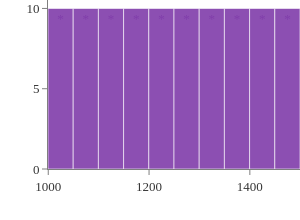

In [6]:
gen.next()

**Наблюдения:**  

- В таблице users 500 уникльных пользователей.


Values,500 (100%),,Max,75,,Avg,46.59,,53 (3%)
Missing,---,,95%,72.05,,Mode,---,,42 (3%)
Distinct,58 (12%),,75%,62,,Range,57,,63 (3%)
Duplicates,442 (88%),,Median,46,,iQR,30,,64 (3%)
Zeros,---,,25%,32,,std,16.67,,71 (3%)
Negative,---,,5%,21,,kurt,-1.20,,73 (2%)
RAM (Mb),<1 Mb,,Min,18,,skew,-0.00,,21 (2%)

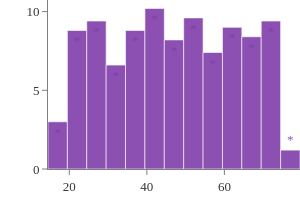

In [7]:
gen.next()

**Наблюдения:**  

- Пользователи имеют возраст от 18 до 75 лет
- В основном пользователи имеют возраст от 32 до 62 лет.


Values,500 (100%),,Москва (20%)
Missing,---,,Санкт-Петербург (8%)
Distinct,76 (15%),,Новосибирск (3%)
Duplicated origin,424 (85%),,Казань (3%)
Dupl (modify - origin),---,,Омск (3%)
Empty,---,,Уфа (2%)
RAM (Mb),<1 Mb,,Набережные Челны (2%)

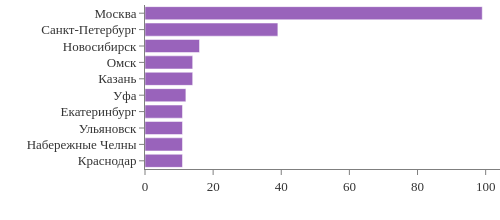

In [8]:
gen.next()

**Наблюдения:**  

- Больше всего пользователей из Москвы и Санкт-Петербурга.


Values,500 (100%),,Радим (1%)
Missing,---,,Леонид (1%)
Distinct,246 (49%),,Пётр (1%)
Duplicated origin,254 (51%),,Андрей <1%
Dupl (modify - origin),---,,Адам <1%
Empty,---,,Марта <1%
RAM (Mb),<1 Mb,,Тамара <1%

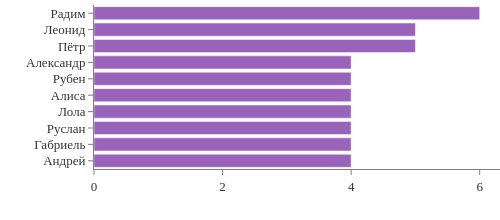

In [9]:
gen.next()

**Наблюдения:**  

- Больше всего пользователей с именем Радим


Values,500 (100%),,Андреенко (1%)
Missing,---,,Березина <1%
Distinct,419 (84%),,Аркадьев <1%
Duplicated origin,81 (16%),,Булгаков <1%
Dupl (modify - origin),---,,Соловьев <1%
Empty,---,,Алексеенко <1%
RAM (Mb),<1 Mb,,Анищенко <1%

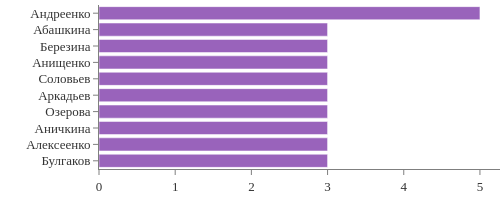

In [10]:
gen.next()

**Наблюдения:**  

- Больше всего пользователей с фамилией Андреенко.


Values,500 (100%),,smart (70%)
Missing,---,,ultra (30%)
Distinct,2 (<1%),,
Duplicated origin,498 (99.6%),,
Dupl (modify - origin),---,,
Empty,---,,
RAM (Mb),<1 Mb,,

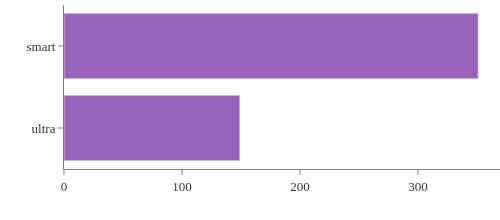

In [11]:
gen.next()

**Наблюдения:**  

- У большинства (70%) пользователей тариф smart


##### Таблица calls (информация о звонках)

In [12]:
df_calls = pd.read_csv('https://code.s3.yandex.net/datasets/calls.csv'
                       , parse_dates=['call_date'], date_format='%Y-%m-%d')
df_calls.sample(5, random_state=7)

,id,call_date,duration,user_id
73455,1185_249,2018-10-19,14.37,1185
12917,1033_168,2018-08-17,12.56,1033
74950,1186_772,2018-04-27,0.00,1186
189799,1467_66,2018-12-15,0.00,1467
165787,1409_412,2018-11-04,2.69,1409


Изучим каждый столбец отдельно.

In [13]:
gen = pagri_data_tools.info_gen(df_calls)
gen.next()

Rows,Features,RAM (Mb),Duplicates,Dupl (sub - origin)
202 607,4,16,---,---


In [14]:
gen.next()

First date,2018-01-01 00:00:00,,Zeros,---,,Years missing,0%,
Last date,2018-12-31 00:00:00,,Missing,---,,Months missing,0%,
Values,202 607 (100%),,Distinct,365 (<1%),,Weeks missing,0%,
RAM (Mb),2,,Duplicates,202 242 (99.8%),,Days missing,0%,


**Наблюдения:**  

- Пропусков и нулевых значений нет.
- Присутствуют данные за каждый день. 


Values,202 607 (100%),,Max,38,,Avg,6.76,,0 (20%)
Missing,---,,95%,17.52,,Mode,0,,4.49 <1%
Distinct,2 871 (1%),,75%,10.7,,Range,38,,5.5 <1%
Duplicates,199 736 (99%),,Median,6,,iQR,9.4,,6.15 <1%
Zeros,39 613 (20%),,25%,1.3,,std,5.84,,6.38 <1%
Negative,---,,5%,0,,kurt,-0.11,,4.92 <1%
RAM (Mb),2,,Min,0,,skew,0.69,,5.05 <1%

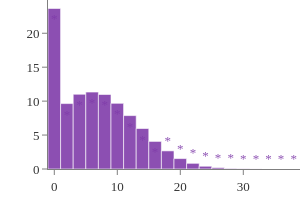

In [15]:
gen.next()

**Наблюдения:**  

- В колонке с длительностью звонка 20 процентов нулей.
- Максимальная длительность звонка 38 минут.
- Длительность звонка варьируется от 0 до 38 минут.
- В основном длительность звонка находится в диапазоне от 1.3 до 10.7 минут.
- Чаще всего звонок составляет 0 минут.

Values,202 607 (100%),,Max,1 499,,Avg,1 253.94,,1 377 <1%
Missing,---,,95%,1 472,,Mode,1 377,,1 168 <1%
Distinct,492 (<1%),,75%,1 379,,Range,499,,1 375 <1%
Duplicates,202 115 (99.8%),,Median,1 260,,iQR,253,,1 453 <1%
Zeros,---,,25%,1 126,,std,144.72,,1 196 <1%
Negative,---,,5%,1 027,,kurt,-1.24,,1 021 <1%
RAM (Mb),2,,Min,1 000,,skew,-0.05,,1 363 <1%

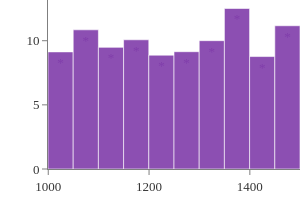

In [16]:
gen.next()

**Наблюдения:**  

- В таблице users 492 уникальных пользователя. 

Values,202 607 (100%),,1000_0 <1%
Missing,---,,1344_881 <1%
Distinct,202 607 (100%),,1344_883 <1%
Duplicated origin,---,,1344_884 <1%
Dupl (modify - origin),---,,1344_885 <1%
Empty,---,,1344_886 <1%
RAM (Mb),11,,1344_887 <1%

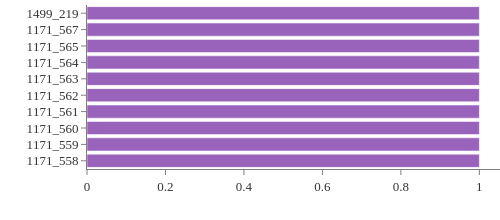

In [17]:
gen.next()

**Наблюдения:**  

- Все id звонков уникальны. Так и должно быть. 

##### Таблица messages (информация о сообщениях)

In [18]:
df_messages = pd.read_csv('https://code.s3.yandex.net/datasets/messages.csv'
                       , parse_dates=['message_date'], date_format='%Y-%m-%d')
df_messages.sample(5, random_state=7)

,id,message_date,user_id
15098,1065_434,2018-08-27,1065
33764,1146_562,2018-08-25,1146
49985,1222_189,2018-09-02,1222
101044,1413_3,2018-11-27,1413
43573,1188_36,2018-06-28,1188


Изучим каждый столбец отдельно.

In [19]:
gen = pagri_data_tools.info_gen(df_messages)
gen.next()

Rows,Features,RAM (Mb),Duplicates,Dupl (sub - origin)
123 036,3,9,---,---


In [20]:
gen.next()

First date,2018-01-02 00:00:00,,Zeros,---,,Years missing,0%,
Last date,2018-12-31 00:00:00,,Missing,---,,Months missing,0%,
Values,123 036 (100%),,Distinct,364 (<1%),,Weeks missing,0%,
RAM (Mb),1,,Duplicates,122 672 (99.7%),,Days missing,0%,


Values,123 036 (100%),,Max,1 499,,Avg,1 256.99,,1 277 (1%)
Missing,---,,95%,1 475,,Mode,1 277,,1 089 (1%)
Distinct,426 (<1%),,75%,1 381,,Range,499,,1 231 (1%)
Duplicates,122 610 (99.7%),,Median,1 271,,iQR,247,,1 385 (1%)
Zeros,---,,25%,1 134,,std,143.52,,1 356 <1%
Negative,---,,5%,1 026,,kurt,-1.18,,1 004 <1%
RAM (Mb),1,,Min,1 000,,skew,-0.11,,1 344 <1%

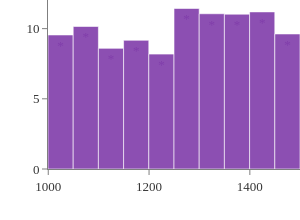

In [21]:
gen.next()

**Наблюдения:**  

- В таблице с информацией о сообщениях 426 уникальных пользователя.  

Values,123 036 (100%),,1000_0 <1%
Missing,---,,1344_248 <1%
Distinct,123 036 (100%),,1344_96 <1%
Duplicated origin,---,,1344_95 <1%
Dupl (modify - origin),---,,1344_94 <1%
Empty,---,,1344_93 <1%
RAM (Mb),7,,1344_92 <1%

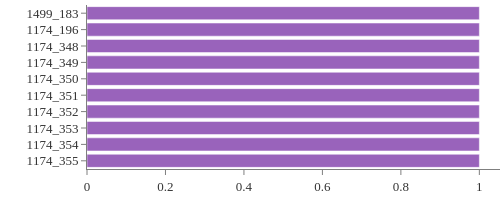

In [22]:
gen.next()

**Наблюдения:**  

- Все id сообщений уникальный. Так и должно быть.

##### Таблица internet (информация об интернет-сессиях)

In [23]:
df_internet = pd.read_csv('https://code.s3.yandex.net/datasets/internet.csv'
                       , parse_dates=['session_date'], date_format='%Y-%m-%d', index_col=0).reset_index(drop=True)
df_internet.sample(5, random_state=7)

,id,mb_used,session_date,user_id
109657,1373_579,0.00,2018-05-31,1373
5266,1015_274,91.12,2018-08-22,1015
69602,1238_194,381.53,2018-11-04,1238
65465,1224_111,461.78,2018-04-26,1224
139810,1469_198,163.69,2018-09-08,1469


Изучим каждый столбец отдельно.

In [24]:
gen = pagri_data_tools.info_gen(df_internet)
gen.next()

Rows,Features,RAM (Mb),Duplicates,Dupl (sub - origin)
149 396,4,11,---,---


In [25]:
gen.next()

First date,2018-01-01 00:00:00,,Zeros,---,,Years missing,0%,
Last date,2018-12-31 00:00:00,,Missing,---,,Months missing,0%,
Values,149 396 (100%),,Distinct,365 (<1%),,Weeks missing,0%,
RAM (Mb),1,,Duplicates,149 031 (99.8%),,Days missing,0%,


Values,149 396 (100%),,Max,1 724.83,,Avg,370.19,,0 (13%)
Missing,---,,95%,866.52,,Mode,0,,335.91 <1%
Distinct,70 003 (47%),,75%,559.55,,Range,1 724.83,,447.3 <1%
Duplicates,79 393 (53%),,Median,348.01,,iQR,421.37,,197.56 <1%
Zeros,19 598 (13%),,25%,138.19,,std,278.3,,199.11 <1%
Negative,---,,5%,0,,kurt,-0.28,,379.69 <1%
RAM (Mb),1,,Min,0,,skew,0.51,,292.14 <1%

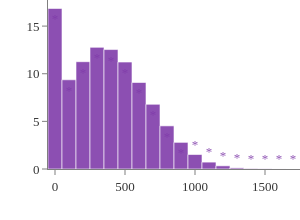

In [26]:
gen.next()

**Наблюдения:**  

- В колонке с объемом интернет-трафика 13 процентов нулей.
- За одну сессию пользователи тратят от 0 до 1 724.83 мегабайт
- В основном пользователи тратят от 138.19 до 559.55 мегабайт

Values,149 396 (100%),,Max,1 499,,Avg,1 252.1,,1 496 <1%
Missing,---,,95%,1 476,,Mode,1 496,,1 227 <1%
Distinct,497 (<1%),,75%,1 380,,Range,499,,1 204 <1%
Duplicates,148 899 (99.7%),,Median,1 251,,iQR,250,,1 240 <1%
Zeros,---,,25%,1 130,,std,144.05,,1 251 <1%
Negative,---,,5%,1 025,,kurt,-1.20,,1 385 <1%
RAM (Mb),1,,Min,1 000,,skew,-0.02,,1 072 <1%

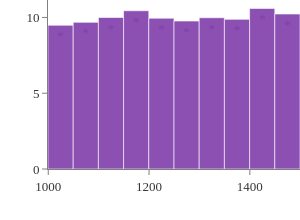

In [27]:
gen.next()

**Наблюдения:**  

- В таблице с информацией о интернет-сессиях 497 уникальных пользователей.

Values,149 396 (100%),,1000_0 <1%
Missing,---,,1333_109 <1%
Distinct,149 396 (100%),,1334_0 <1%
Duplicated origin,---,,1334_1 <1%
Dupl (modify - origin),---,,1334_2 <1%
Empty,---,,1334_3 <1%
RAM (Mb),8,,1334_4 <1%

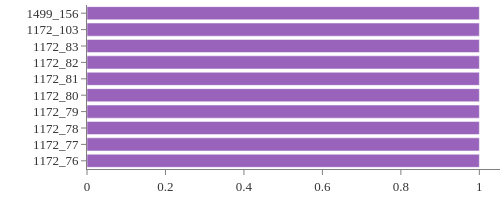

In [28]:
gen.next()

##### Таблица tariffs (информация о тарифах)

In [29]:
dtype = {'tariff_name': 'category'}
df_tariffs = pd.read_csv('https://code.s3.yandex.net/datasets/tariffs.csv', nrows=5)
df_tariffs    

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Соберем все датафреймы в словарь для удобства дальнейшей работы.

In [30]:
dfs = dict(
    users = df_users
    , calls = df_calls
    , messages = df_messages
    , internet = df_internet
    , tariffs = df_tariffs
)

#### Изучение дубликатов


Посмотрим на дубли во всем датафрейме


In [31]:
for key, df in dfs.items():
    display(f'{key} - {pagri_data_tools.check_duplicated(df)}')

'users - no duplicates'

'calls - no duplicates'

'messages - no duplicates'

'internet - no duplicates'

'tariffs - no duplicates'

Полных дубликатов у нас нет в датафреймах

Посмотрим сколько у нас дублей в каждой колонке


Таблица users (информация о пользователях)

In [32]:
series_duplicated = pagri_data_tools.find_columns_with_duplicates(df_users)

age,442 (88.40%)
churn_date,466 (93.20%)
city,424 (84.80%)
first_name,254 (50.80%)
last_name,81 (16.20%)
reg_date,230 (46.00%)
tariff,498 (99.60%)


Таблица calls (информация о звонках)

In [33]:
series_duplicated = pagri_data_tools.find_columns_with_duplicates(df_calls)

call_date,202242 (99.82%)
duration,199736 (98.58%)
user_id,202115 (99.76%)


Таблица messages (информация о сообщениях)

In [34]:
series_duplicated = pagri_data_tools.find_columns_with_duplicates(df_messages)

message_date,122672 (99.70%)
user_id,122610 (99.65%)


Таблица internet (информация об интернет-сессиях)

In [35]:
series_duplicated = pagri_data_tools.find_columns_with_duplicates(df_internet)

mb_used,79393 (53.14%)
session_date,149031 (99.76%)
user_id,148899 (99.67%)


Таблица tariffs (информация о тарифах)

In [36]:
series_duplicated = pagri_data_tools.find_columns_with_duplicates(df_tariffs)

There are no duplicated values


Дубликаты присутствуют там, где они могут быть, поэтому все в порядке.

Проверим есть ли у нас в таблице df_users пользователи с одними и теми же именом и фамилией

In [37]:
filtered_df = df_users[['first_name', 'last_name']]
pagri_data_tools.check_duplicated(filtered_df)

'no duplicates'

#### Изучение пропусков


Таблица users (информация о пользователях)

In [38]:
series_missed = pagri_data_tools.find_columns_with_missing_values(df_users)

churn_date,462 (92.40%)


**Наблюдения:**  

- В данном случае пропуски нормально, они означают, что пользователь не прекратил использовать тариф

Таблица calls (информация о звонках)

In [39]:
series_missed = pagri_data_tools.find_columns_with_missing_values(df_calls)

There are no missing values


Таблица messages (информация о сообщениях)

In [40]:
series_missed = pagri_data_tools.find_columns_with_missing_values(df_messages)

There are no missing values


Таблица internet (информация об интернет-сессиях)

In [41]:
series_missed = pagri_data_tools.find_columns_with_missing_values(df_internet)

There are no missing values


Таблица tariffs (информация о тарифах)

In [42]:
series_missed = pagri_data_tools.find_columns_with_missing_values(df_tariffs)

There are no missing values


Отлично. Пропуски у нас только в колоноке с датой прекращения пользования тарифом. И они означают, что пользователь еще пользуется тарифом.

#### Изучение выбросов


При изучении каждой колонки по отдельности выбросы не были обнаружены. 

Посмотрим на выбросы используя квантили.    
Выбросами будем считать значения, которые выходят за пределы 5 и 95 квантилей.

Таблица users (информация о пользователях)

In [43]:
series_outliers = pagri_data_tools.detect_outliers_quantile(df_users)

user_id,50 (10.00%)
age,49 (9.80%)


**Наблюдения:**  

- Около 10 процентов пользователей попали в выбрсоы

Таблица calls (информация о звонках)

In [44]:
series_outliers = pagri_data_tools.detect_outliers_quantile(df_calls)

duration,10105 (4.99%)
user_id,19650 (9.70%)


**Наблюдения:**  

- Около 5 процентов звонков попали в выбрсоы

Таблица messages (информация о сообщениях)

In [45]:
series_outliers = pagri_data_tools.detect_outliers_quantile(df_messages)

user_id,12030 (9.78%)


Таблица internet (информация об интернет-сессиях)

In [46]:
series_outliers = pagri_data_tools.detect_outliers_quantile(df_internet)

mb_used,7470 (5.00%)
user_id,14401 (9.64%)


**Наблюдения:**  

- Около 5 процентов интернет-сессий попали в выбрсоы

Таблица tariffs (информация о тарифах)

In [47]:
series_outliers = pagri_data_tools.detect_outliers_quantile(df_tariffs)

messages_included,2 (100.00%)
mb_per_month_included,2 (100.00%)
minutes_included,2 (100.00%)
rub_monthly_fee,2 (100.00%)
rub_per_gb,2 (100.00%)
rub_per_message,2 (100.00%)
rub_per_minute,2 (100.00%)


#### Изучение отрицательных значений


Посмотрим есть ли у нас отрицательные значения

In [48]:
series_negative = pagri_data_tools.find_columns_with_negative_values(df_users)

There are no negative values


Таблица calls (информация о звонках)

In [49]:
series_negative = pagri_data_tools.find_columns_with_negative_values(df_calls)

There are no negative values


Таблица messages (информация о сообщениях)

In [50]:
series_negative = pagri_data_tools.find_columns_with_negative_values(df_messages)

There are no negative values


Таблица internet (информация об интернет-сессиях)

In [51]:
series_negative = pagri_data_tools.find_columns_with_negative_values(df_internet)

There are no negative values


Таблица tariffs (информация о тарифах)

In [52]:
series_negative = pagri_data_tools.find_columns_with_negative_values(df_tariffs)

There are no negative values


Отлично. Отрицательных значений нет.

#### Изучение нулевых значений


Посмотрим есть ли у нас колонки с нулевыми значениями

In [53]:
series_zeros = pagri_data_tools.find_columns_with_zeros_values(df_users)

There are no zeros values


Таблица calls (информация о звонках)

In [54]:
series_zeros_calls = pagri_data_tools.find_columns_with_zeros_values(df_calls)

duration,39613 (19.55%)


Таблица messages (информация о сообщениях)

In [55]:
series_zeros = pagri_data_tools.find_columns_with_zeros_values(df_messages)

There are no zeros values


Таблица internet (информация об интернет-сессиях)

In [56]:
series_zeros_internet = pagri_data_tools.find_columns_with_zeros_values(df_internet)

mb_used,19598 (13.12%)


Таблица tariffs (информация о тарифах)

In [57]:
series_zeros = pagri_data_tools.find_columns_with_zeros_values(df_tariffs)

There are no zeros values


У нас нули в длительности звонков и в объеме интернет-трафика.  


In [58]:
duration_zeros = series_zeros_calls['duration']
mb_used_zeros = series_zeros_internet['mb_used']

In [59]:
common_users_with_zeros = set(duration_zeros['user_id']).intersection(set(df_internet['user_id']))
len(common_users_with_zeros)

491

Лишь 488 одинаковых пользователей. Получается нет зависимости от пользователей.  

Посмотрим в разрезе названия тарифа на нулевые значения

In [60]:
duration_merged = pd.merge(duration_zeros[['user_id', 'duration']], df_users[['user_id', 'tariff']])

In [61]:
duration_merged.groupby('tariff', observed=True).size().to_frame('count')

,count
tariff,
smart,25669
ultra,13944


**Наблюдения:**  

- Зависимость от тарифа не обнаружена.

### Промежуточный вывод


- В колонке с датой прекращения пользования тарифом 92 % пропусков. Значит 92 % пользователей ещё пользуются таррифом.
- Есть пропущенные недели и дни в дате прекращения пользования тарифом, но в данном случае это нормально.  
- В колонке с датой подключения тарифа 26 % дней пропущено.
- В таблице users 500 уникльных пользователей.
- Пользователи имеют возраст от 18 до 75 лет
- В основном пользователи имеют возраст от 32 до 62 лет.
- Больше всего пользователей из Москвы и Санкт-Петербурга.
- У большинства (70%) пользователей тариф smart
- В колонке с длительностью звонка 20 процентов нулей.
- Максимальная длительность звонка 38 минут.
- Длительность звонка варьируется от 0 до 38 минут.
- В основном длительность звонка находится в диапазоне от 1.3 до 10.7 минут.
- Чаще всего звонок составляет 0 минут.
- В таблице users 492 уникальных пользователя. 
- В колонке с объемом интернет-трафика 13 процентов нулей.
- За одну сессию пользователи тратят от 0 до 1 724.83 мегабайт
- В основном пользователи тратят от 138.19 до 559.55 мегабайт
- В таблице с информацией о интернет-сессиях 497 уникальных пользователей.

## Предобработка данных


### Обработка выбросов


У нас нулевые значения в таблице calls в поле duration.   
И у нас нулевые значения в таблице internet в поле mb_used.

In [62]:
pagri_data_tools.check_zeros_value_in_df(df_calls)

,zeros
duration,39613 (19.6%)


In [63]:
pagri_data_tools.check_zeros_value_in_df(df_internet)

,zeros
mb_used,19598 (13.1%)


В длительности звонков нулями обозначены пропущенные звонки, поэтому их обрабатывать не нужно.  

Нули в объеме трафика тоже нормально.  

### Обработка пропусков


Пропуски у нас только в колоноке с датой прекращения пользования тарифом. И они означают, что пользователь еще пользуется тарифом.  
Не будем их обрабатывать.

### Промежуточный вывод


- Не стали обрабатывать пропуски в дате прекращения пользования тарифом, так как эти пропуски показывают, что пользователь ещё пользуется тарифом.  
- Нули в длительности звонка и в объеме интернет трафика не стали обрабатывать, чтобы не исказить данные.

## Обогащение данных и создание новых переменных

### Категоризация данных


Создадим новую категориальную переменную активен ли тариф

In [64]:
df_users['is_active'] = df_users['churn_date'].isna().astype('category')

Создадим новую категориальную переменную с возрастными группами.  

Сделаем следующие группы

- до 30 лет
- от 30 до 40 лет
- от 40 до 50 лет
- от 50 до 60 лет
- старше 60 лет


In [65]:
labels = ['до 30', '30-40', '40-50', '50-60', 'старше 60']
bins = [-np.inf, 30, 40, 50, 60, np.inf]

In [66]:
df_users['age_cat'] = pagri_data_tools.create_category_column(df_users.age, labels=labels, bins=bins)

Values,500 (100%),,старше 60 (26%)
Missing,---,,до 30 (23%)
Distinct,5 (1%),,40-50 (18%)
Duplicated origin,495 (99%),,50-60 (17%)
Dupl (modify - origin),---,,30-40 (16%)
Empty,---,,
RAM (Mb),<1 Mb,,

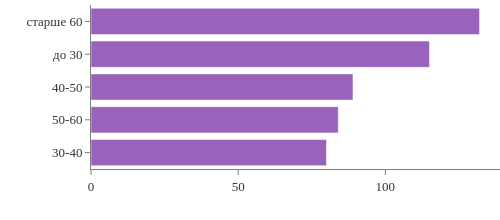

In [67]:
gen = pagri_data_tools.info_gen(df_users, column='age_cat', mode='column')
gen.next()

**Наблюдения:**  

- Большинство пользователей в возрасте старше 60 лет.

Создадим новую категориальную переменную из длительности звонка.  
Посмотрим на распределение длительности звонка по квантилям.  

In [68]:
pagri_data_tools.quantiles_columns(df_calls.duration)

Max,38
95,17.52
75,10.7
50,6
25,1.3
5,0
Min,0


Сделаем следующие группы

- короткий
- средний
- длительный


In [69]:
labels = ['короткий', 'средний', 'длительный']
bins = [-np.inf, 2, 10, np.inf]

In [70]:
df_calls['duration_cat'] = pagri_data_tools.create_category_column(df_calls.duration, labels=labels, bins=bins)

Values,202 607 (100%),,средний (43%)
Missing,---,,длительный (28%)
Distinct,3 (<1%),,короткий (28%)
Duplicated origin,202 604 (99.9%),,
Dupl (modify - origin),---,,
Empty,---,,
RAM (Mb),<1 Mb,,

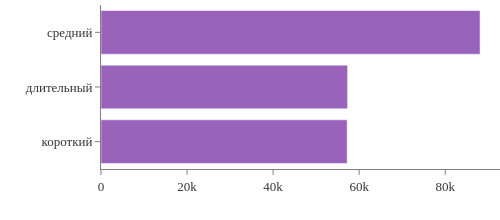

In [71]:
gen = pagri_data_tools.info_gen(df_calls, column='duration_cat', mode='column')
gen.next()

**Наблюдения:**  

- Большинство звонков средней длительности.

Создадим новую категориальную переменную из объема интернет трафика.  
Посмотрим на распределение длительности звонка по квантилям.  

In [72]:
pagri_data_tools.quantiles_columns(df_internet.mb_used)

Max,1 724.83
95,866.52
75,559.55
50,348.01
25,138.19
5,0
Min,0


Сделаем следующие группы

- низкий
- средний
- высокий

In [73]:
labels = ['низкий', 'средний', 'высокий']
bins = [-np.inf, 100, 600, np.inf]

In [74]:
df_internet['mb_used_cat'] = pagri_data_tools.create_category_column(df_internet.mb_used, labels=labels, bins=bins)

Values,149 396 (100%),,средний (58%)
Missing,---,,низкий (21%)
Distinct,3 (<1%),,высокий (21%)
Duplicated origin,149 393 (99.9%),,
Dupl (modify - origin),---,,
Empty,---,,
RAM (Mb),<1 Mb,,

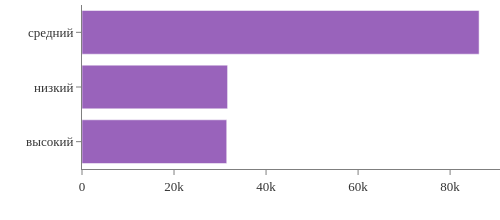

In [75]:
gen = pagri_data_tools.info_gen(df_internet, column='mb_used_cat', mode='column')
gen.next()

**Наблюдения:**  

- Основная часть трафика среднего объема.  

Создаем новые переменные из времени

In [76]:
weekday_dict = {
    'Monday': 'Понедельник',
    'Tuesday': 'Вторник',
    'Wednesday': 'Среда',
    'Thursday': 'Четверг',
    'Friday': 'Пятница',
    'Saturday': 'Суббота',
    'Sunday': 'Воскресенье'
}
month_dict = {
    1: 'Январь',
    2: 'Февраль',
    3: 'Март',
    4: 'Апрель',
    5: 'Май',
    6: 'Июнь',
    7: 'Июль',
    8: 'Август',
    9: 'Сентябрь',
    10: 'Октябрь',
    11: 'Ноябрь',
    12: 'Декабрь'
}

In [77]:
df_users['reg_date_weekday'] = df_users['reg_date'].dt.day_name().map(weekday_dict).astype('category')
df_users['reg_date_month'] = df_users['reg_date'].dt.month.map(month_dict).astype('category')
# Задаем порядок для weekdays
weekday_order = ['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота', 'Воскресенье']
df_users['reg_date_weekday'] = df_users['reg_date_weekday'].cat.reorder_categories(weekday_order, ordered=True)

# Задаем порядок для months
month_order = ['Январь', 'Февраль', 'Март', 'Апрель', 'Май', 'Июнь', 'Июль', 'Август', 'Сентябрь', 'Октябрь', 'Ноябрь', 'Декабрь']
df_users['reg_date_month'] = df_users['reg_date_month'].cat.reorder_categories(month_order, ordered=True)


Values,500 (100%),,Вторник (17%)
Missing,---,,Пятница (16%)
Distinct,7 (1%),,Понедельник (15%)
Duplicated origin,493 (99%),,Воскресенье (14%)
Dupl (modify - origin),---,,Суббота (14%)
Empty,---,,Среда (13%)
RAM (Mb),<1 Mb,,Четверг (12%)

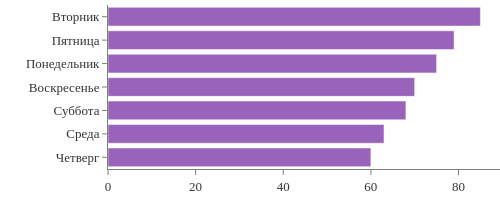

In [78]:
gen = pagri_data_tools.info_gen(df_users, column='reg_date_weekday', mode='column')
gen.next()

Values,500 (100%),,Апрель (11%)
Missing,---,,Август (10%)
Distinct,12 (2%),,Октябрь (9%)
Duplicated origin,488 (98%),,Июль (9%)
Dupl (modify - origin),---,,Январь (9%)
Empty,---,,Ноябрь (8%)
RAM (Mb),<1 Mb,,Май (8%)

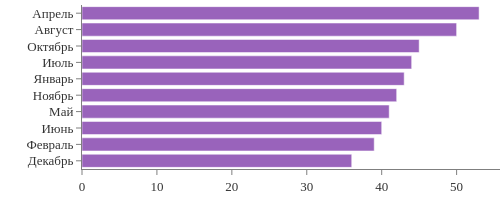

In [79]:
gen = pagri_data_tools.info_gen(df_users, column='reg_date_month', mode='column')
gen.next()

In [80]:
df_calls['call_date_weekday'] = df_calls['call_date'].dt.day_name().map(weekday_dict).astype('category')
df_calls['call_date_month'] = df_calls['call_date'].dt.month.map(month_dict).astype('category')
# Задаем порядок для weekdays
weekday_order = ['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота', 'Воскресенье']
df_calls['call_date_weekday'] = df_calls['call_date_weekday'].cat.reorder_categories(weekday_order, ordered=True)

# Задаем порядок для months
month_order = ['Январь', 'Февраль', 'Март', 'Апрель', 'Май', 'Июнь', 'Июль', 'Август', 'Сентябрь', 'Октябрь', 'Ноябрь', 'Декабрь']
df_calls['call_date_month'] = df_calls['call_date_month'].cat.reorder_categories(month_order, ordered=True)


Values,202 607 (100%),,Понедельник (15%)
Missing,---,,Воскресенье (15%)
Distinct,7 (<1%),,Суббота (14%)
Duplicated origin,202 600 (99.9%),,Пятница (14%)
Dupl (modify - origin),---,,Четверг (14%)
Empty,---,,Вторник (14%)
RAM (Mb),<1 Mb,,Среда (14%)

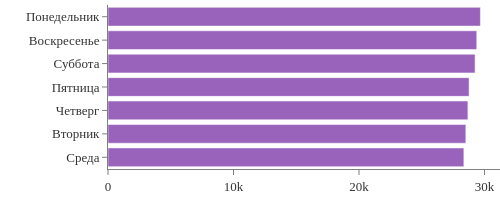

In [81]:
gen = pagri_data_tools.info_gen(df_calls, column='call_date_weekday', mode='column')
gen.next()

Values,202 607 (100%),,Декабрь (17%)
Missing,---,,Ноябрь (15%)
Distinct,12 (<1%),,Октябрь (13%)
Duplicated origin,202 595 (99.9%),,Сентябрь (12%)
Dupl (modify - origin),---,,Август (11%)
Empty,---,,Июль (9%)
RAM (Mb),<1 Mb,,Июнь (7%)

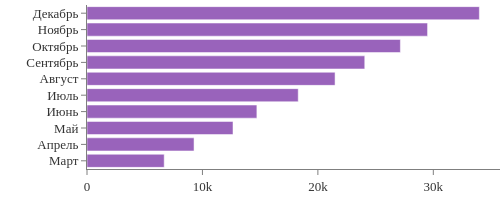

In [82]:
gen = pagri_data_tools.info_gen(df_calls, column='call_date_month', mode='column')
gen.next()

**Наблюдения:**  

- Больше всего звонков было в декабре и ноябре.

In [83]:
df_messages['message_date_weekday'] = df_messages['message_date'].dt.day_name().map(weekday_dict).astype('category')
df_messages['message_date_month'] = df_messages['message_date'].dt.month.map(month_dict).astype('category')
# Задаем порядок для weekdays
weekday_order = ['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота', 'Воскресенье']
df_messages['message_date_weekday'] = df_messages['message_date_weekday'].cat.reorder_categories(weekday_order, ordered=True)

# Задаем порядок для months
month_order = ['Январь', 'Февраль', 'Март', 'Апрель', 'Май', 'Июнь', 'Июль', 'Август', 'Сентябрь', 'Октябрь', 'Ноябрь', 'Декабрь']
df_messages['message_date_month'] = df_messages['message_date_month'].cat.reorder_categories(month_order, ordered=True)


Values,123 036 (100%),,Понедельник (15%)
Missing,---,,Воскресенье (14%)
Distinct,7 (<1%),,Суббота (14%)
Duplicated origin,123 029 (99.9%),,Пятница (14%)
Dupl (modify - origin),---,,Среда (14%)
Empty,---,,Четверг (14%)
RAM (Mb),<1 Mb,,Вторник (14%)

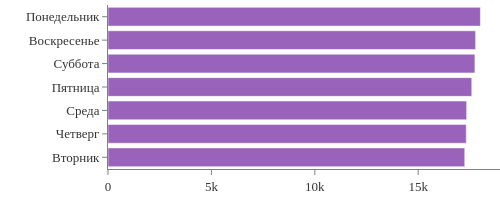

In [84]:
gen = pagri_data_tools.info_gen(df_messages, column='message_date_weekday', mode='column')
gen.next()

Values,123 036 (100%),,Декабрь (17%)
Missing,---,,Ноябрь (15%)
Distinct,12 (<1%),,Октябрь (14%)
Duplicated origin,123 024 (99.9%),,Сентябрь (12%)
Dupl (modify - origin),---,,Август (11%)
Empty,---,,Июль (9%)
RAM (Mb),<1 Mb,,Июнь (7%)

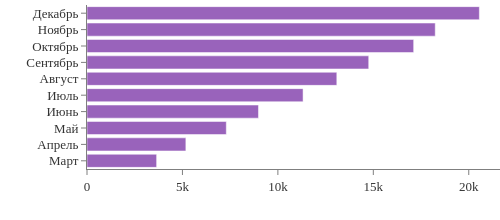

In [85]:
gen = pagri_data_tools.info_gen(df_messages, column='message_date_month', mode='column')
gen.next()

**Наблюдения:**  

- Больше всего звонков было в декабре и ноябре.

In [86]:
df_internet['session_date_weekday'] = df_internet['session_date'].dt.day_name().map(weekday_dict).astype('category')
df_internet['session_date_month'] = df_internet['session_date'].dt.month.map(month_dict).astype('category')
# Задаем порядок для weekdays
weekday_order = ['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота', 'Воскресенье']
df_internet['session_date_weekday'] = df_internet['session_date_weekday'].cat.reorder_categories(weekday_order, ordered=True)

# Задаем порядок для months
month_order = ['Январь', 'Февраль', 'Март', 'Апрель', 'Май', 'Июнь', 'Июль', 'Август', 'Сентябрь', 'Октябрь', 'Ноябрь', 'Декабрь']
df_internet['session_date_month'] = df_internet['session_date_month'].cat.reorder_categories(month_order, ordered=True)


Values,149 396 (100%),,Понедельник (15%)
Missing,---,,Воскресенье (15%)
Distinct,7 (<1%),,Пятница (14%)
Duplicated origin,149 389 (99.9%),,Четверг (14%)
Dupl (modify - origin),---,,Суббота (14%)
Empty,---,,Среда (14%)
RAM (Mb),<1 Mb,,Вторник (14%)

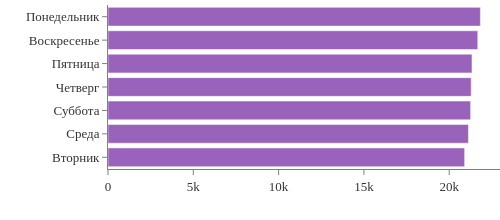

In [87]:
gen = pagri_data_tools.info_gen(df_internet, column='session_date_weekday', mode='column')
gen.next()

Values,149 396 (100%),,Декабрь (17%)
Missing,---,,Ноябрь (15%)
Distinct,12 (<1%),,Октябрь (13%)
Duplicated origin,149 384 (99.9%),,Сентябрь (12%)
Dupl (modify - origin),---,,Август (11%)
Empty,---,,Июль (9%)
RAM (Mb),<1 Mb,,Июнь (7%)

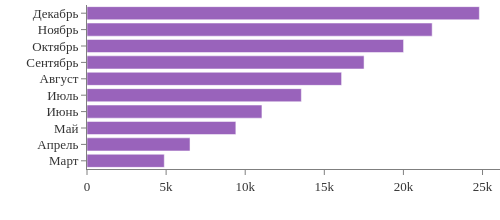

In [88]:
gen = pagri_data_tools.info_gen(df_internet, column='session_date_month', mode='column')
gen.next()

- Больше всего тратили интернет трафик в декабре и ноябре.

### Объединение данных


Создадим дополнительные таблицы для анализа

Создадим отдельные таблицы для анализа выручки для звонков, сообщений и интернета.

In [89]:
print('len of df_calls = ', len(df_calls))
print('len of df_messages = ', len(df_messages))
print('len of df_internet = ', len(df_internet))

len of df_calls =  202607
len of df_messages =  123036
len of df_internet =  149396


In [90]:
df_calls_full = df_calls.merge(df_users, on='user_id', how='left')
df_messages_full = df_messages.merge(df_users, on='user_id', how='left')
df_internet_full = df_internet.merge(df_users, on='user_id', how='left')

In [91]:
print('len of calls_users = ', len(df_calls_full))
print('len of messages_users = ', len(df_messages_full))
print('len of internet_users = ', len(df_internet_full))

len of calls_users =  202607
len of messages_users =  123036
len of internet_users =  149396


Количество строк не изменилось, все хорошо. 

### Расчет метрик


Создадим таблицу с аггрегацией по месяцам и рассчитаем различные метрики

In [92]:
df_calls_by_month_for_revenue = df_calls.groupby(['user_id', 'call_date_month'], observed=True)[['duration']].sum().reset_index().rename(columns={'call_date_month': 'month'})
len(df_calls_by_month_for_revenue)

3174

In [93]:
df_messages_by_month_for_revenue = df_messages.groupby(['user_id', 'message_date_month'], observed=True)[['id']].agg(message_cnt=('id', 'count')).reset_index().rename(columns={'message_date_month': 'month'})
len(df_messages_by_month_for_revenue)

2717

In [94]:
df_internet_by_month_for_revenue = df_internet.groupby(['user_id', 'session_date_month'], observed=True)[['mb_used']].sum().reset_index().rename(columns={'session_date_month': 'month'})
len(df_internet_by_month_for_revenue)

3203

Объеденим таблицы

In [95]:
df_by_userid_month = df_calls_by_month_for_revenue.merge(df_messages_by_month_for_revenue, on=['user_id', 'month'], how='outer')
len(df_by_userid_month)

3213

In [96]:
df_by_userid_month = df_by_userid_month.merge(df_internet_by_month_for_revenue, on=['user_id', 'month'], how='outer')
len(df_by_userid_month)

3214

In [97]:
df_by_userid_month = df_by_userid_month.merge(df_users, on='user_id')
len(df_by_userid_month)

3214

In [98]:
df_by_userid_month = df_by_userid_month.merge(df_tariffs.rename(columns={'tariff_name': 'tariff'}), on='tariff')
len(df_by_userid_month)

3214

Занулим пропуски, чтобы рассчитать общую выручку. 

In [99]:
df_by_userid_month.duration = df_by_userid_month.duration.fillna(0)
df_by_userid_month.message_cnt = df_by_userid_month.message_cnt.fillna(0)
df_by_userid_month.mb_used = df_by_userid_month.mb_used.fillna(0)

Рассчитаем выручку

In [100]:
df_by_userid_month['revenue'] = ((df_by_userid_month.duration - df_by_userid_month.minutes_included) * df_by_userid_month.rub_per_minute).clip(lower=0)
df_by_userid_month['revenue'] += ((df_by_userid_month.message_cnt - df_by_userid_month.messages_included) * df_by_userid_month.rub_per_message).clip(lower=0)
df_by_userid_month['revenue'] += ((df_by_userid_month.mb_used - df_by_userid_month.mb_per_month_included) / 1024 * df_by_userid_month.rub_per_gb).clip(lower=0)
df_by_userid_month['revenue'] += df_by_userid_month.rub_monthly_fee
df_by_userid_month['revenue'] = df_by_userid_month['revenue'].round(2)

Изучим отедльно столбец с выручкой

Values,3 214 (100%),,Max,6 542.88,,Avg,1 461.88,,1 950 (27%)
Missing,---,,95%,2 758.03,,Mode,1 950,,550 (19%)
Distinct,1 677 (52%),,75%,1 950,,Range,5 992.88,,553 <1%
Duplicates,1 537 (48%),,Median,1 514.19,,iQR,1 293.06,,589 <1%
Zeros,---,,25%,656.94,,std,777.96,,616 <1%
Negative,---,,5%,550,,kurt,1.28,,604 <1%
RAM (Mb),<1 Mb,,Min,550,,skew,0.75,,568 <1%

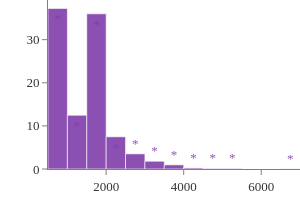
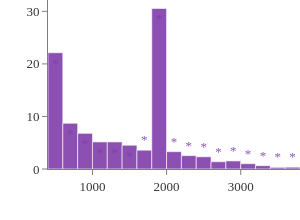

In [121]:
gen = pagri_data_tools.info_gen(df_by_userid_month, column='revenue', mode='column')
gen.next('dual')

**Наблюдения:**  

- На гистограмме выручки присутствуют 2 пика. Это связанно с абоненской платой, так как у нас 2 тарифа
- Месячная выручка по пользователям варьируется от 550 до 6 542.88рублей.
- В основном выручка лежит в диапазоне от 656.94 до 1 950 рублей.
- В тарифе премиум чаще не превышают лимит по тарифу. Это видно по самым распространенным значениям в выручке.  

Рассчитаем среднее количество звонков в день

In [101]:
calls_metrics = df_calls.groupby(['user_id', 'call_date_month'], observed=True).agg(
    total_calls=('id', 'count'),
    active_days_calls=('call_date', 'nunique')
).reset_index().rename(columns={'call_date_month': 'month'})

In [102]:
df_by_userid_month = df_by_userid_month.merge(calls_metrics, on=['user_id', 'month'], how='left')

In [103]:
df_by_userid_month['calls_per_day'] = df_by_userid_month['total_calls'] / df_by_userid_month['active_days_calls']
df_by_userid_month[['total_calls', 'active_days_calls', 'calls_per_day']] = df_by_userid_month[['total_calls', 'active_days_calls', 'calls_per_day']].fillna(0)

Values,3 214 (100%),,Max,100,,Avg,2.65,,3 (2%)
Missing,---,,95%,4.2,,Mode,3,,2 (2%)
Distinct,724 (23%),,75%,3,,Range,100,,1 (1%)
Duplicates,2 490 (77%),,Median,2.48,,iQR,1.05,,2.5 (1%)
Zeros,40 (1%),,25%,1.95,,std,2.58,,0 (1%)
Negative,---,,5%,1.37,,kurt,854.13,,1.5 <1%
RAM (Mb),<1 Mb,,Min,0,,skew,25.89,,2.33 <1%

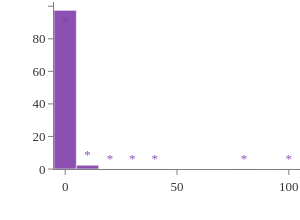
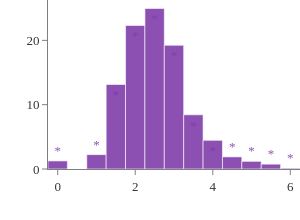

In [122]:
gen = pagri_data_tools.info_gen(df_by_userid_month, column='calls_per_day', mode='column')
gen.next('dual')

**Наблюдения:**  

- Средняя количество звонков в день варьируется от 0 до 100.
- В основном пользователи совершают от 1.95 до 3 звонков в день.

Среднее количество сообщений в день

In [104]:
messages_metrics = df_messages.groupby(['user_id', 'message_date_month'], observed=True).agg(
    total_messages=('id', 'count'),
    active_days_messages=('message_date', 'nunique')
).reset_index().rename(columns={'message_date_month': 'month'})

In [105]:
df_by_userid_month = df_by_userid_month.merge(messages_metrics, on=['user_id', 'month'], how='left')

In [106]:
df_by_userid_month['messages_per_day'] = df_by_userid_month['total_messages'] / df_by_userid_month['active_days_messages']
df_by_userid_month[['total_messages', 'active_days_messages', 'messages_per_day']] = df_by_userid_month[['total_messages', 'active_days_messages', 'messages_per_day']].fillna(0)

Values,3 214 (100%),,Max,51.67,,Avg,1.8,,0 (15%)
Missing,---,,95%,3.83,,Mode,0,,1 (6%)
Distinct,622 (19%),,75%,2.33,,Range,51.67,,2 (2%)
Duplicates,2 592 (81%),,Median,1.67,,iQR,1.15,,1.33 (2%)
Zeros,497 (15%),,25%,1.18,,std,1.64,,1.5 (2%)
Negative,---,,5%,0,,kurt,312.94,,1.25 (1%)
RAM (Mb),<1 Mb,,Min,0,,skew,12.08,,1.67 (1%)

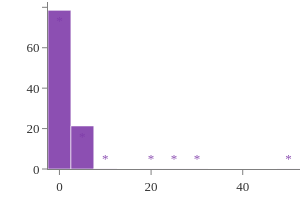
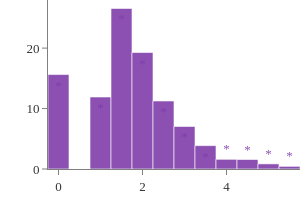

In [123]:
gen = pagri_data_tools.info_gen(df_by_userid_month, column='messages_per_day', mode='column')
gen.next('dual')

**Наблюдения:**  

- Средняя количество сообщений в день варьируется от 0 до 51.67
- В основном пользователи отправляют от 1.18 до 2.33 сообщений в день.

Среднее количество интернет сессий в день

In [107]:
internet_metrics = df_internet.groupby(['user_id', 'session_date_month'], observed=True).agg(
    total_sessions=('id', 'count'),
    active_days_internet=('session_date', 'nunique')
).reset_index().rename(columns={'session_date_month': 'month'})

In [108]:
df_by_userid_month = df_by_userid_month.merge(internet_metrics, on=['user_id', 'month'], how='left')

In [109]:
df_by_userid_month['sessions_per_day'] = df_by_userid_month['total_sessions'] / df_by_userid_month['active_days_internet']
df_by_userid_month[['total_sessions', 'active_days_internet', 'sessions_per_day']] = df_by_userid_month[['total_sessions', 'active_days_internet', 'sessions_per_day']].fillna(0)

Values,3 214 (100%),,Max,58,,Avg,2.13,,2 (5%)
Missing,---,,95%,2.85,,Mode,2,,1.5 (2%)
Distinct,504 (16%),,75%,2.35,,Range,58,,1.67 (1%)
Duplicates,2 710 (84%),,Median,2.05,,iQR,0.6,,2.33 (1%)
Zeros,11 (<1%),,25%,1.75,,std,1.74,,1.75 <1%
Negative,---,,5%,1.33,,kurt,704.02,,2.5 <1%
RAM (Mb),<1 Mb,,Min,0,,skew,24.83,,1 <1%

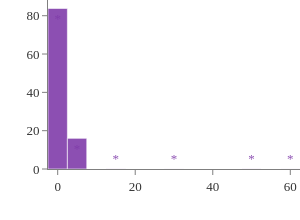
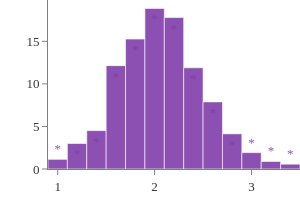

In [124]:
gen = pagri_data_tools.info_gen(df_by_userid_month, column='sessions_per_day', mode='column')
gen.next('dual')

**Наблюдения:**  

- Пользователи проводят от 0 до 58 интернет-сессий в день.
- В основном пользователи проводят от 1.75 до 2.35 интернет-сесси в день.

Средняя длина звонка

In [111]:
df_by_userid_month['avg_call_duration'] = (df_by_userid_month['duration'] / df_by_userid_month['total_calls']).round(2)

Values,3 214 (100%),,Max,58,,Avg,2.13,,2 (5%)
Missing,---,,95%,2.85,,Mode,2,,1.5 (2%)
Distinct,504 (16%),,75%,2.35,,Range,58,,1.67 (1%)
Duplicates,2 710 (84%),,Median,2.05,,iQR,0.6,,2.33 (1%)
Zeros,11 (<1%),,25%,1.75,,std,1.74,,1.75 <1%
Negative,---,,5%,1.33,,kurt,704.02,,2.5 <1%
RAM (Mb),<1 Mb,,Min,0,,skew,24.83,,1 <1%

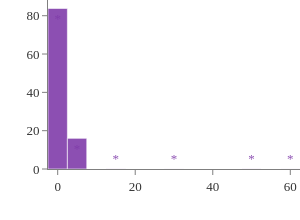
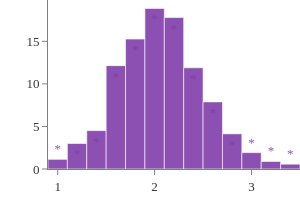

In [125]:
gen = pagri_data_tools.info_gen(df_by_userid_month, column='sessions_per_day', mode='column')
gen.next('dual')

**Наблюдения:**  

- Средняя длительность звонка в день варьируется от 0 до 58 минут.
- В основном звонки длятся от 1.75 до 2.35 минут.

ARPU

In [112]:
df_arpu = df_by_userid_month.groupby(['month', 'city', 'is_active', 'age_cat', 'tariff'], observed=True).agg(
    revenue = ('revenue', 'sum'),
    users = ('user_id', 'nunique')).reset_index()
df_arpu['arpu'] = df_arpu['revenue'] / df_arpu['users']

### Промежуточный вывод


- На гистограмме выручки присутствуют 2 пика. Это связанно с абоненской платой, так как у нас 2 тарифа
- Месячная выручка по пользователям варьируется от 550 до 6 542.88рублей.
- В основном выручка лежит в диапазоне от 656.94 до 1 950 рублей.
- В тарифе премиум чаще не превышают лимит по тарифу. Это видно по самым распространенным значениям в выручке.  
- Средняя количество звонков в день варьируется от 0 до 100.
- В основном пользователи совершают от 1.95 до 3 звонков в день.
- Средняя количество сообщений в день варьируется от 0 до 51.67
- В основном пользователи отправляют от 1.18 до 2.33 сообщений в день.
- Пользователи проводят от 0 до 58 интернет-сессий в день.
- В основном пользователи проводят от 1.75 до 2.35 интернет-сесси в день.
- Средняя длительность звонка в день варьируется от 0 до 58 минут.
- В основном звонки длятся от 1.75 до 2.35 минут.
- Создадим новую категориальную переменную активен ли тариф
- Создадим новую категориальную переменную с возрастными группами.  
- Большинство пользователей в возрасте старше 60 лет.
- Создадим новую категориальную переменную из длительности звонка.  
- Большинство звонков средней длительности.
- Создадим новую категориальную переменную из объема интернет трафика.  
- Основная часть трафика среднего объема.  
- Из временных переменных создали новые переменные месяц и день недели
- Больше всего звонков было в декабре и ноябре.
- Создали отдельные таблицы для анализа выручки для звонков, сообщений и интернета.
- Создали таблицу с аггрегацией по пользователю и месяцу. И рассчитали следующие метрики
    - выручка
    - среднее количество звонков в день
    - среднее количество сообщений в день
    - среднее количество интернет-сессий день
    - средняя длина звонка
- Создали таблицу для анализа arpu по разным категориальным переменным.

## Визуализация взаимосвязей переменных


### Исследование корреляционных связей

In [114]:
titles_for_axis= dict(
        calls_per_day = 'среднее количество звонков в день',
        sessions_per_day = 'среднее количество интернет-сессий в день',
        revenue = 'выручка',
        mb_used = 'количество интернет-трафика',
)
pagri_data_tools.heatmap_corr(df_by_userid_month[['sessions_per_day', 'calls_per_day', 'revenue', 'mb_used']], titles_for_axis= titles_for_axis)

**Наблюдения:**  

- Сильная положительная корреляция между количеством интернет-сессий в день и количеством звонков в день
- Умеренная положительная корреляция между выручкой  и количеством интернет трафика в день

### Изучение зависимостей между числовыми переменными


Построим диаграммы рассеяния для числовых переменных


In [ ]:
titles_for_axis = dict(
    # numeric column
    revenue = 'выручка'
    , mb_used = 'количество интернет-трафика, мб'
    , duration = 'длительность звонка в минутах'
    , active_days_internet = 'количество дней интернет сессий'    
    , total_calls = 'количество звонков'
    , total_sessions = 'количество интернет сессий'
)

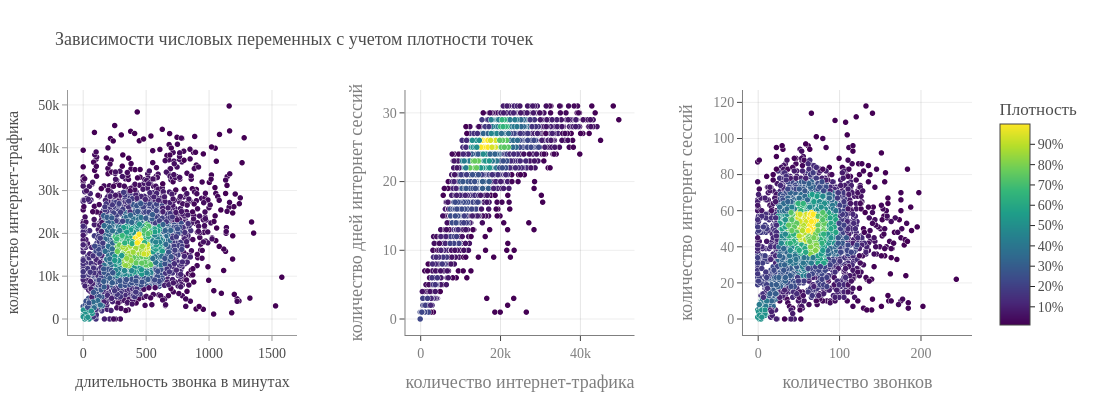

In [135]:
pairs = {('duration', 'mb_used'): {'duration': [np.float64(0.0), np.float64(1578.06)], 'mb_used': [np.float64(0.0), np.float64(49745.69)]}, ('mb_used', 'active_days_internet'): {'mb_used': [np.float64(0.0), np.float64(49745.69)], 'active_days_internet': [np.float64(0.0), np.float64(31.0)]}, ('total_calls', 'total_sessions'): {'total_calls': [np.float64(0.0), np.float64(244.0)], 'total_sessions': [np.float64(0.0), np.float64(118.0)]}}
pagri_data_tools.pairplot_pairs(df_by_userid_month, pairs, titles_for_axis=titles_for_axis, horizontal_spacing=0.12, rows=1, cols=3, height=400, width=1100).show(config=dict(displayModeBar=False, dpi=200), renderer="png")

**Наблюдения:**  

- Чем больше длительность звонка в минутах, тем больше количество интернет-трафика. Правда зависимость слабая.
- Чем больше количество дней интернет сессий, тем больше количество интернет-трафика. Что логично. 
- Есть небольшая зависимость между количеством звонков и количеством интернет сессий.

### Изучение зависимостей между категориальными переменными


In [ ]:
f'Среднее / Медианное / Суммарное {numeric} в зависимости от {category} и {category}'  

In [ ]:
titles_for_axis = dict(
    # numeric column (0 - средний род, 1 - мужской род, 2 - женский род) (Середнее образовние, средний доход, средняя температура) )
    children = ['Количество детей', 'количество детей', 0]
    , age = ['Возраст, лет', 'возраст', 1]
    , total_income = ['Ежемесячный доход', 'ежемесячный доход', 1]    
     # category column
    , education = ['Уровень образования', 'уровня образования']
    , family_status = ['Семейное положение', 'семейного положения']
    , gender = ['Пол', 'пола']
    , income_type = ['Тип занятости', 'типа занятости']
    , debt = ['Задолженность (1 - имеется, 0 - нет)', 'задолженности']
    , purpose = ['Цель получения кредита', 'цели получения кредита']
    , dob_cat = ['Возрастная категория, лет', 'возрастной категории']
    , total_income_cat = ['Категория дохода', 'категории дохода']
)

In [ ]:
_gen_ 

In [ ]:
import sys
sys.path.append('/home/pagri/git_repos/pagri_private_modules')
import pagri_dash
pagri_dash.category_analysis_dash(df_arpu, "/home/pagri/git_repos/pagri-projects/quarto/projects/prospective_tariff_for_telecom/temp_for_report.ipynb")

> Строим матрицу тепловой карты для категориальных переменных и изучаем зависимости  


Чтобы в dash app выбрать нужные пары для scatterplot   
ставим  `_gen_` в месте где хотим чтобы появились ячейки с кодом для постройки графиков      
далее используем  `pagri_dash.scatterplot_analysis_dash`

In [ ]:
_gen_ 

In [ ]:
import sys
sys.path.append('/home/pagri/git_repos/pagri_private_modules')
import pagri_dash
pagri_dash.categorical_heatmap_matrix_dash(df, "/home/pagri/git_repos/pagri-projects/quarto/projects/housing-ads-investigation/temp.ipynb")

> Посмотрим на распределение количества элементов между группами


> Нужно подумать как отобразить не только процент от всего количества, но и пороцент в группе  
> То есть у нас есть значение в ячейке, сумма всех, сумма по категории на оси x и сумма по категории на оси Y  
> Вот нужно как-то отобразить процент от суммы, процент от одной категории и от другой категории


In [ ]:
12 (0.5% of total, 20% of row, 15% of col) 

> Можно сделать кнопки, чтобы можно было подсветку делать внури колонок и строк


> Можно сделать кнопки (процент от общего) (процент от тут указывается название оси x) (аналогично для второй оси)


In [ ]:
pagri_data_tools.categorical_graph_analys_gen()

> Строим treemap  
> `treemap`  
> `treemap_dash`
>
> ```
> app = treemap_dash(df)
> if __name__ == '__main__':
>    app.run_server(debug=True)
> ```


In [ ]:
pagri_data_tools.treemap()

In [ ]:
app = pagri_data_tools.treemap_dash(df)
if __name__ == '__main__':
    app.run_server(debug=True)

> Строим parallel_categories  
> `parallel_categories `  
> `parallel_categories_dash `
>
> ```
> app = treemap_dash(df)
> if __name__ == '__main__':
>    app.run_server(debug=True)
> ```


In [ ]:
pagri_data_tools.parallel_categories()

In [ ]:
app = pagri_data_tools.parallel_categories_dash(df)
if __name__ == '__main__':
    app.run_server(debug=True)

> Строим Sankey  
> `sankey `  
> `sankey_dash`
>
> ```
> app = treemap_dash(df)
> if __name__ == '__main__':
>    app.run_server(debug=True)
> ```


In [ ]:
pagri_data_tools.sankey()

In [ ]:
app = pagri_data_tools.sankey_dash(df)
if __name__ == '__main__':
    app.run_server(debug=True)

### Анализ временных зависимостей


Когда мы хотим изучить верменную зависимость, то нам нуно создать новые переменные с обрезанными (trunc or round) значениям, чтобы можно было сгруппировать используя groupby or pivot_table  
по этой обрезанной переменной и применить функцию агрегации и построить график, например, среднее время заправки на азс по часам.  
Вот когда мы работаем с временем, нам нужно думать какие переменные создать, обрезая текущее время.


> Строим когортный анализ, если есть возможность


> Если у нас есть даты, то мы можем посмотреть не просто абсолютные значения на каждую дату какой-то метрики,  
> а посмотреть относительные значения относительно предыдущего значения.  
> Для этого нужно составить таблицу, в которой будет изменение в процентах относительно предыдущего значения.  
> И затем визуализировать для каждой даты динамику этого показателя


### Изучение зависимостей между числовыми и категориальными переменными


добавить слайдер как доп переменную и анимация будет сразу

In [ ]:
df = px.data.gapminder()

fig = px.bar(df, x="continent", y="pop", color="continent",
  animation_frame="year", animation_group="country", range_y=[0,4000000000], width=900, height=500)
fig.show()

Важно когда мы смотрем очередной график, то задавать не только вопросы к данным, но и думать как можно отфильтровать  
данные, чтобы сделать дополнительные полезные выводы.  
То есть мы фильтруем данные и потом эти графики поместим в раздел с анализом срезов.  

> Можно добавить кнопку среднее и количество  
> Чтобы можно было посмотртеть распределение по количеству, когда смотрить среднее.


In [ ]:
_gen_ 

Добавить в hover количество элементов в группе,  
чтобы понимать размер группы.

Добавить возможность перескакивать комбинации.  
Если много колонок, то комбинаций очень много и часть может быть просто не нужна для анализа.  

Изучаем следующим образом  
- смотрим на график и определяем есть ли взаимодейсвие (то есть отличаются ли значения в разных группах, это будет видно как разная высота баров)
- если разницы в барах нет, или она минимальная, то сразу можно пропускать
- если разница есть, то думаем важна ли для нас ээта комбинация столбцов
- если нет, то пропускаем
- если да, то пишем наблюдения и сохраняем

Не забываем смотреть 1_cat чтобы изучить отдельную категорию.  
То есть график появлился, смотрим на обе категории и на числовую переменную и думаем, нужно ли нам по отдельности изучить  
каждую категориальную переменную c числовой. Если уже изучили, то не изучаем.
Нужно подумать как сохранять уже изученые комбинации, чтобы не повторяться (может в dash app добавить всплывающее окно, для графиков, для которых уже был вывод, что уже было)

Нужно сделать в dash app чтобы было 4 графика 
- каждая категория с числвой (2 графика)
- и по 2 категории вместе с числовой для разной последовательности категорий (то есть сначала одна легенда, потом другая)  
Так будет удобно и в браузере есть место для 4 графиков.

In [ ]:
import sys
sys.path.append('/home/pagri/git_repos/pagri_private_modules')
import pagri_dash
pagri_dash.numeric_category_analysis_dash(df, "/home/pagri/git_repos/pagri-projects/quarto/projects/housing-ads-investigation/temp.ipynb")

### Анализ срезов данных 

Срезы нужно обязательно сравнить со всем датафреймом.  
То есть мы например, изучили центр города и нужно сделать выводы основываясь на сравнении центра и всего города.

Нужно создать 2 генератора и параллельно идти, чтобы сначала выводился срез, а потом уже целый датафрейм.  
Тут наша задача не изучать выбросы, дубли и прочее.  
Тут задача найти отличия среза от всего датафрейма.

Возможно лучше прйти все колонки так попарно, а потом выбрать только те, которые имеют отличия.  
И построить только их.

Срезы нужны не только чтобы изучить отдельно часть данных, важно сравнивать срез со всем датафреймом.  
Нужно подумать какие срезы будет полезно сравнить со всем датафреймом.  
И провести сравнительный анализ. И поместить в отчет то, что имеет отличия и важно для выводов.

сделать приложение dash чтобы можно было выбирать колонки для анализа,  
чтобы можно было фильтровать по всем категориальным переменным,  
чтобы были слайдеры для фильтрации по числовым переменным,
чтобы можно было выбирать типы графиков и строить разные графики.  
Это не генератор, а это для ad-hoc анализа.   
То есть мы подумали что интересно будет изучить этот срез и эти переменные и изучили.  
А потом можно подумать как это автоматиировать, чтобы в цикле строились нужные графики.  

Анализ срезов состоит из анализа срезов из одного значения, то есть мы выбираем конкретное значени и по  нему фильтруем.  
и анализа срезов из нескольких переменных, когда мы выбираем несколько значений для среза или даже несколько переменных и в них выбираем определенные значения.  

Анализ срезов по одному значению мы просто фильтруем по нему и смотрим результат функции `info_gen` или 'info_column'  

А анализ срезво по нескольким значениям или переменным будет результатом анализа графиков в dash app.  
То есть мы в процессе анализа фильтруем данные и после работы в dahs app мы фильтрованные графики помещаюем в этот раздел.  
Чтобы разделить срезы и полный анализ.  

Нужно подумать как лучше изучать срезы.  
В данном разделе лучше изучить срезы отдельных значений, то есть отдельный город, отдельный пол и прочее.  
То есть мы фильтруем по одному значению и его изучаем в функцией `info`  
А изучение срезов данных, которые состоят из набора значений (например изучить цену в топ 10 городах), это уже будет сделано  
в анализе графиков.  

Тут мы изучаем подготовленный набор данных в разрезе разных категориальных переменных.  
Задача посмотреть на отдельные срезы и найти закономерности в данных.  

Например у нас есть данные о продажах квартир, мы создали новые категориальные перменные, обогатили данные  
И теперь хотим посмотреть какое распределение цены только в центре, или какая площадь квартир возле парков и прочее.  
То есть мы тут изучаем отдельно переменные в разрезе категорий, то есть строим срезы.  
ВАжно, что тут мы изучаем отедльные переменные, срезы в зависимостях переменных будем строить в разаделе визуализации. 

Определить цель. Прежде чем начинать анализ срезов, важно четко определить, какие вопросы вы хотите ответить или какие гипотезы хотите проверить. Это может включать:
- Сравнение различных групп (например, по возрасту, полу, региону).
- Изучение влияния определенных факторов на целевую переменную.
- Выявление аномалий или неожиданных паттернов в данных.

Выбор переменных для срезов. Выберите переменные, по которым вы хотите сделать срезы. Это могут быть как категориальные, так и количественные переменные. Примеры:
- Категориальные переменные: пол, категория товара, регион, уровень образования.
- Количественные переменные: возраст, доход, количество покупок (то есть мы можем просто взять срез с зарплатой до 100 тысяч и прочее, не обязательно иметь категорию для создания срезов, причем у нас может быть категория доходов, но срез мы можем взять в другом диапазоне).

Важно когда мы выбрали параметры по которым хотим сделать срез, то далее нужно выбрать условие по которому мы будем создавать срез.  
Срез это фильтрация или группировка, то есть должна быть либо функция аггрегации или значения по которым мы будем фильтровть.  
Например мы для среза выбрали параметр города. Теперь нам нужно отобрать города для среза.  
Мы выбираем параметр количество объявлений (все зависит от цели, можно было выбрать и количество населения, значение других параметров, все что поможет нам создать топ)
И далее по нему фильтруем или аггрегируем.  

Срезы данных можно создавать различными способами. Вот несколько подходов:
- Фильтрация данных: Используйте условия для выбора подмножеств данных.  
Например, выберите только тех клиентов, которые находятся в определенном регионе или имеют доход выше определенного порога.  
- Группировка данных: Используйте функции группировки (например, groupby в pandas для Python) для агрегирования данных по выбранным переменным.   
Это позволяет вам получить сводные статистики по группам.
- Кросс-табуляция: Для категориальных переменных создайте кросс-таблицы, чтобы увидеть взаимосвязи между переменными.

Анализ срезов. После создания срезов данных проведите анализ:
- Статистический анализ: Рассчитайте основные статистики (среднее, медиана, стандартное отклонение) для каждой группы или среза. Это поможет вам понять, как различаются группы по ключевым показателям.
- Визуализация: Постройте графики для визуального представления данных. Это могут быть:  
Гистограммы для распределения количественных переменных.  
Столбчатые графики для сравнения категориальных переменных.  
Ящики с усами (boxplots) для визуализации разброса и выявления аномалий.  
- Сравнительный анализ: Сравните срезы между собой. Например, как различается средний доход мужчин и женщин или как меняется поведение клиентов в зависимости от региона.

Если мы для среза выбрали одно значение (например конкретный город), то мы просто посмотреть результат функции`info` и проанализировать его  
Но если мы выбрали для среза набор значений, то нам нужно уже построить графики для сравнения стат параметров или других аггреигующих параметров  
для каждого занчения в срезе. То есть нам нужно выбрать параметры по которым мы будем сравнивать значения в срезе.  

Фильруем датасет по определенному значению и далее либо изучаем по отедльным столбцам, либо по всем испоьзуя генератор

То есть мы изучаем срез по одному значению

Созадем 2 генератора (или больше, если хотим сравнить несколько срезов), для среза и всего датафрейма и идем изучаем их вместе.  

Нужно сделать отдельный генератор, чтобы в нем не было информации про пропуски, нули и прочее,   
И организовать так, чтобы было удобно сравнивать.  
Также гистограммы нужно сделать на одном графике, чтобы накладывлись друг на друга и сделать прозрачность.    
Это очень удобно и если гистограммы будут накладываться друг на друга, то можно будет увидеть сразу отличия средних и мод на графике.    
В идеале сделать, чтобы были не столбцы, а типа каги, то есть линия со ступеньками, так удобнее сравнивать гистограммы. 

ОЧЕНЬ ВАЖНО  
- в наблюдения пишем обязательно диапазон значений столбца.  
Рынок жилья представлен объектами общей площадью от 12 до 900 кв.м. 
- пишем медианное занчение и по гистограмме и по квантилям определяем оснвоной диапазон.  
В основном это жилье от 30 до 100 кв.м. с пиком в сегменте 30-75 кв.м  
Это все нужно, чтобы потом сформулировать вот такой вывод (в оснвоном выводе отчета), то есть мы для разных столбцов пишем диапазоны,  
основной дипазаон, медианы, моды, а потом уже собираем это в 1 или несколько выводов,  
Например.  
Рынок жилья представлен объектами общей площадью от 12 до 900 кв.м. В основном это жилье от 30 до 100 кв.м. с пиком в сегменте 30-75 кв.м. В жилой площади квартиры преобладает диапазон 15-50 кв.м. Размер площади кухни-от 5 до 15 кв.м., с пиком 9 кв.м. Это стандартные небольшие квартиры эконом-класса. Подавляющее большинство квартир- 1-3 комнатные, с высотой потолка 2,6-2,7 м., но встречаются редкие варианты до 19 комнат и высотой потолка до 20 кв.м. (либо ошибка, либо свободная планировка с возможностью многоуровневости).


В итоге мы сраним диапазоны, моды, медианы в срезе и во всем датафйреме.  


Было бы идеально определить отличия в срезе и в общей картине, не просто сухими цифрами,  
а собрать все наблюдения вместе и расписать это в подобном виде-   
Рынок недвижимости центральной части города представлен несколько более широким по площади диапазоном : основная масса- это жилье от 30 до 150 кв.м с пиком в сегменте 45-80 кв.м. При этом жилая площадь занимает большую долю, чем среднестатистическая квартира: в центре СПб большое количество домов старой застройки, в которой пространство "сдвинуто" в пользу жилой площади. Особенностью этой части города является то, что большинство квартир, предлагаемых на продажу,- 2-3 комнатные: здесь в общей массе достаточно низкая доля 1-комнатного жилья и выше доля 4-комнатных квартир. Наибольшее количество предложений в абсолютном выражении (цена за объект) приходится на диапазон 5-15 млн.руб. с пиком 5-8 млн.руб.(маленькие квартиры эконом-класса), но есть и уникальные объекты стоимостью до 35 млн.руб. Стоимость квадратного метра недвижимости в основном варьируется от 70 до 150 тыс.руб. с пиком в 100 тыс.руб. Наряду с типовыми предложениями на продажу выставлено жилье со стоимостью 1 кв.м. до 266 тыс.руб за кв.м. В целом цены жилья центра города выше по цене, чем аналогичное в других районах.

In [ ]:
df_sliced = df[df.location_zone == 'Центр']
gen_slice = pagri_data_tools.info_gen(df_sliced)
gen = pagri_data_tools.info_gen(df)

In [ ]:
next(gen_slice)
next(gen)

Если есть что-то важное и есть отличия, по которым можно сделать выводы, то строим отдельно в отчет

In [ ]:
print('Центр города')
pagri_data_tools.info_column(df_sliced, 'last_price')
print('Весь датафрейм')
pagri_data_tools.info_column(df, 'last_price')

**Наблюдения:**  
- пишем тут наблюдения

ВАЖНО  
Сравниваем не только отдельные столбцы с общей картиной.  
Нужно взять срез и посмотреть на корреляцию, зависимости между числовыми, категориальными и т.д.  
Как это делали для всего датафрейма, только в укороченной версии, то есть можно взять общей картины, что мы нашли интересного  
(то есть взять названия столбцов) и посмотреть на эти же графики, но уже в срезах.  
Если есть время, то можно и полностью прогнать все необходимые срезы по всем столбцам как для всего датафрейма.  

Полезно изучить топ определенного столбца.  
То есть нам нужно выбрать параметр по которому мы отберем топ значений для категорий.  
Затем выбрать параметр для которого мы будем считать топ значений (числовая переменная)
И построить топ.  
Например, топ цен квартир в 10 городах с максимальным количеством объявлений.  


In [ ]:
selected_cities = df.groupby('locality_name').size().rename('count').sort_values(ascending=False).to_frame().head(10)
selected_cities

In [ ]:
selected_cities = selected_cities.index

In [ ]:
config = dict(
    df = df[df.locality_name.isin(selected_cities)]
    , x = 'locality_name'
    , x_axis_label = 'Название населённого пункта'
    , y = 'price_per_sqm'
    , y_axis_label = 'Цена квадратного метра'
    , title = 'Цена кв метра в зависимости от населенного пункта'
    , func = 'mean'
    , width = None
    , height = None
    , orientation = 'v'
)
pagri_data_tools.bar(config)

### Когортный анализ


> Не забывать про когортный анализ. Если у нас есть параметр, по которому мы можем наши данные разбить на когорты, то  
> нужно разложить на когорты и посмотреть динамику по когортам.  
> Когорты это например, пользователи пришедшие в одни день или месяц.  
> Если мы объеденим пользователей в когорты и посмотрим динамику какого-то параметра по месяцам например, то увидим как изменяется.  
> Тут также нужно помнить, что если значение например за 3 месяц больше значения за 4 месяц, то это ничего не значит само по себе.  
> Так как мы имеем дело с выборкой, то нам нужно проверить статистически значимая это разница.  
> Тут нам понядобятся стат тесты.


### Промежуточный вывод


ВАЖНО  
подумать для каждого раздела в визуализации (временные, числовые, категориальные и числовые с категориальными)  
какие закономерности не проверил.  
убедиться, что все зависимости, которые были в задании изучили.  
Это самый важный моменты, тут лучше остановится и тщательно подумать,  
так как могут быть изучены не все зависимости.

ВАЖНО   
Убедиться, что сетки по осям стоят где нужно, часто для вертикальных или горизонатльных графиков лишняя сетка вдоль баров

## Формулирование и провера гипотез


### Формулирование гипотез


ВАЖНО  
это редко бывает, но нужно об этом помнить  
Когда мы хотим проверить какую-то гипотезу на основе среднего или другой статистики, то нужно подумать нет ли сильного разделения на группы  
по какой-нибудь категориальной переменной.  
Если у нас есть такое разделение, то нужно использовать стратифицированную выборку.  
То есть мы должны взять выборку из каждой группы пропорционально её размеру.  
Считаем коэффициенты каждой группы (ее размер делим на количество всей выборки) и умнажаем их на количество нужных элементов.  
То есть мы из каждой страты возьмем прпорциональное количество элементов.  
Нарпимер, мы хотим сравнить средние значения дохода в двух компаниях.  
И берем по 100 сотрудников из каждой. Без стратификации у нас редкие сотрудники могут не попасть.  
Поэтому мы берем категориальную переменную (например должность) и делим выборку на группы. И из каждой берем пропорциональное количество элементов.

Смотрим выводы и из них формулируем гипотезы.  

И далее думаем какие гипотезы можно ещё проверить, которых у нас нет в выводах.  

> На основе проведенного анализа данных сформулирем следующие гипотезы:


> Гипотеза 1: Нет зависимость между наличием детей и возвратом кредита в срок.  
> Гипотеза 2: У мужчин средний доход выше  
> Гипотеза 3: Цель получения кредита не зависит от среднего ежемесяченого доход  
> Гипотеза 4: Средний доход по семейному статусу одинаковый, но у вдовцов отличается  
> Гипотеза 5: У должников в среднем больше детей  
> Гипотеза 6: У должников средний возраст ниже  
> Гипотеза 7: Медианный доход у должников и не должников не отличается


> Не забываем что гипотезы можно проверять и между 2 категориальными переменными.  
> Проверять есть ли между ними зависимости.  
> Также если мы на графиках определили, что есть между 2 категориальными перменными связь, то тут можем это проверить


### Проверка гипотез


ВАЖНО  
принято в выводе писать положительный результат  
то есть пишем что гипотеза подтвердилась и указваем какая гипотеза.  
То если мы опровергли нулевую гипотезу, то пишем альтернативную гипотезу и пишем что она подтвердилась.  
Если у нас нет оснований отвергнуть нулевую гипотезу, то пишем нулевую гипотезу и пишем что нет оснований ее отвергнуть.  
То есть если мы отвергаем, то формулируем вывод как положительный, чтобы не было путаницы, а если нет оснований, то так и пишем.  

> Проверим сформулированные гипотезы.


> **Гипотеза 1: Название гипотезы**


> H0: The two categorical variables are independent.  
> H1: The two categorical variables are not independent (i.e., there is a significant association between them).


Далее нужно определить какой тест нам нужен

Если у нас 2 категориальные переменные, то тут просто

Если у нас категориальная и числовая, то сначала смотрим на распределение числовой переменной.  
Если сразу решаем использовать не параметрику, то манна уитни или крускал -уоллис.  
Если параметрика, то нужно проверить на равенство дисперсий в группах.  
И далее если равны, то т тест / тест вэлча или anova / anova вэлча.  
Если использовали anova, welch anova, kruskal, то если есть отличия, то используем тест тьюки, чтобы определить какие группы отличаются.

> Примеры гипотез

- Есть ли зависимость между наличием детей и возвратом кредита в срок?


> Это будет часто возникать когда у нас категориальная целевая переменная и другие категориальные переменные.  
> И мы хотим проверить влияют ли категориальные переменные на целевую.  
> Например у нас есть поле наличие долга (есть или нет)  
> Вот тут мы можем провести тесты со всеми каетгориями на наличие зависимости с наличием долга.  
> В идеале мы на графиках должны найти гипотезы и тут их проверить.  
> Но если у нас целевая переменная, то мы можем сравнить ее со всеми категориями


In [ ]:
pagri_data_tools.chi2_pearson()

> Формируем словарь для подписей осей и названия гистограм


In [ ]:
titles_for_axis = dict(
    # numeric column
    children = ['Количество детей', 'количества детей']
    , age = ['Возраст', 'возраста']
    , total_income = ['Ежемесячный доход', 'ежемесячного дохода']    
)

> Нулевая гипотеза должна быть направлена на отсутствие эффекта, а альтернативная гипотеза должна быть направлена на наличие эффекта.


> Формулируем гипотезу через H0, H1


> H0: У мужчин средний доход не выше, чем у женщин  
> H1: У мужчин средний доход выше, чем у женщин


> Смотрим распределение метрики


In [ ]:
pagri_data_tools.histogram(df.total_income, titles_for_axis)

> Делаем вывод о распределении.  
> Выбираем критерий для проверки гипотезы.  
> Определяем уровнь значимости.


> Проводим тест  
> ВАЖНО  
> df в ttest_ind_df и подобных можно испльзовать только для 2 стороннего случая  
> Для одностороннего нужно придумать как определять какая группа первая по порядку пойдет в тест,  
> в зависимости от постановки гипотезы, так как альтернатива опредляется исходя из порядка аргументов в функции теста


> Если используем ттест или анову, то сначала проводим тест на проверку дисперсии


> H0: У должников и не должников дисперсия не отличается  
> H1: У должников и не должников дисперсия отличается


In [ ]:
pagri_data_tools.levene_df
pagri_data_tools.levene
pagri_data_tools.bartlett_df
pagri_data_tools.bartlett

> Выбираем критерий


In [ ]:
pagri_data_tools.chi2_pearson
pagri_data_tools.ttest_ind_df
pagri_data_tools.ttest_ind
pagri_data_tools.mannwhitneyu_df
pagri_data_tools.mannwhitneyu
pagri_data_tools.proportion_ztest_1sample
pagri_data_tools.proportions_ztest_2sample
pagri_data_tools.proportions_ztest_column_2sample
pagri_data_tools.proportions_chi2
pagri_data_tools.proportions_chi2_column
pagri_data_tools.anova_oneway_df
pagri_data_tools.anova_oneway
pagri_data_tools.tukey_hsd_df
pagri_data_tools.anova_oneway_welch_df
pagri_data_tools.kruskal_df
pagri_data_tools.kruskal
pagri_data_tools.bootstrap_diff_2sample # важно, сохраняем fig и в следующей ячейке делаем fig.shwo(), иначе на google colab работает некорректно

> Проводим тест


> Если отклоняем гипотезу, то строим доверитлеьный интервал


In [ ]:
pagri_data_tools.confint_t_2samples
pagri_data_tools.confint_t_2samples_df
pagri_data_tools.confint_proportion_ztest_2sample
pagri_data_tools.confint_proportion_ztest_column_2sample
pagri_data_tools.confint_proportion_2sample_statsmodels
pagri_data_tools.confint_proportion_coluns_2sample_statsmodels

In [ ]:
titles_for_axis = dict(
    # numeric column
    children = ['Количество детей', 'количества детей']
    , age = ['Возраст', 'возраста']
    , total_income = ['Ежемесячный доход', 'ежемесячного дохода']    
)

Примеры для разных критериев

2 категориальные переменные или 1 категориальная переменная и мы хотим сравнить количество в каждой группе.

**Гипотеза 1: Нет зависимость между наличием детей и возвратом кредита в срок**


> H0: Наличие детей не влияет на возврат кредита в срок.  
> H1: Наличие детей влияет на возврат кредита в срок.


> Так как у нас обе переменных категориальные, то воспользуемся критерием хи-квадрат Пирсона.  
> Уровень значимости alpha выберем 0.05


In [ ]:
pagri_data_tools.chi2_pearson(df.has_child, df.debt)

Хи-квадрат Пирсона
alpha =  0.05
p-value =  1.724356890544321e-05
Отклоняем нулевую гипотезу, поскольку p-value меньше уровня значимости


**Результат:**  

На уровне значимости 0.05 нулевая гипотеза о том, что наличие детей не влияет на возврат кредита в срок, была отклонена. Это свидетельствует о том, что существует статистически значимое влияние наличия детей на возврат кредита в срок.


Если мы хотим проверить отличается ли количество в одной категориальной переменной, то используем chisquare

Он проверяет, насколько наблюдаемое распределение категориальной переменной отличается от ожидаемого равномерного распределения.  

**Гипотеза 1: Нет зависимости между количеством публикаций и днем недели.**  

H0: День недели не влияет на количество объявлений  
H1: День недели влияет на количество объявлений

In [ ]:
daily_counts = df['publication_weekday'].value_counts().sort_index()
daily_counts

publication_weekday
Понедельник    3591
Вторник        4157
Среда          3940
Четверг        4270
Пятница        3970
Суббота        1918
Воскресенье    1681
Name: count, dtype: int64

In [ ]:
pagri_data_tools.chisquare(daily_counts)

**Результат:**  

- На уровне значимости 0.05 нулевая гипотеза о том, что день недели не влияет на количество объявлений, была отклонена. Это указывает на то, что существует статистически значимое влияние дня недели на количество объявлений.

Категориальная с 2 значениями и числовая переменная  (т тест или тест манна уитни)

**Гипотеза 2: У мужчин средний доход выше**  

H0: У мужчин средний доход не выше, чем у женщин   
H1: У мужчин средний доход выше, чем у женщин

посмотрим на распределение

In [ ]:
pagri_data_tools.histogram(df.total_income, titles_for_axis)

Если распределение не нормальное или много выбросов или просто нет уверености, что параметрика будет хрошо работать, то используем  
тест манна уитни

Используем критерий Манна-Уитни  
Альтернатива будет - больше  
Уровень значимости alpha выберем 0.05  

In [ ]:
male = df[df.gender=='M']['total_income']
female = df[df.gender=='F']['total_income']

In [ ]:
my_module.mannwhitneyu(male, female, alternative='l')

**Результат:**  

- На уровне значимости 0.05 нулевая гипотеза о том, что у мужчин средний доход не выше, чем у женщин, была отклонена. Это указывает на то, что доход мужчин статистически значимо выше, чем у женщин.

Если мы решили использовать т тест


Проверим гипотезу, что дисперсии в группах не отличаются

H0: У должников и не должников дисперсия не отличается  
H1: У должников и не должников дисперсия отличается

Используем тест Левена


In [ ]:
yes = df[df.debt=='есть']['age']
no = df[df.debt=='нет']['age']

In [ ]:
my_module.levene([yes, no])

Так как дисперсия в группах разная, будем использовать тест Уэлча.  
Уровень значимости alpha выберем 0.05

In [ ]:
my_module.ttest_ind(yes, no, equal_var=False, alternative='s')

Построим доверительный интервал

In [ ]:
my_module.confint_t_2samples(yes, no, equal_var=False, alternative='s')

категориальная переменная, у которой больше 2 значений и числовая. 

Предположения ANOVA:
- Данные должны быть нормально распределены.
- Дисперсии в группах должны быть равны (гомоскедастичность).
- Наблюдения должны быть независимыми.

Если хоть одно из этого не выполняется, то лучше использовать kruskal

**Гипотеза 4: Средний доход по семейному статусу одинаковый, но у вдовцов отличается**  

H0: Средний ежемесячный доход не различается между группами по семейному статусу  
H1: Средний ежемесячный доход различается между группами по семейному статусу  


Используем критерий Краскела-Уоллиса  
Уровень значимости alpha выберем 0.05


In [ ]:
pagri_data_tools.kruskal_df(df[['family_status', 'total_income']])

Используем тест Тьюки, чтобы определить различия между группами  
Уровень значимости alpha выберем 0.05

In [ ]:
pagri_data_tools.tukey_hsd_df(df[['family_status', 'total_income']])

Видим, что гипотеза отвергается в парах где есть вдова / вдовец


**Результат:**  

- На уровне значимости 0.05 нулевая гипотеза о том, что средний ежемесячный доход не различается между группами по семейному статусу, была отклонена.  
Это указывает на то, что семейный статус оказывает статистически значимое влияние на ежемесячный доход.

Бутстреп

Вместо теста манна уитни, когда нет уверености в т тесте, можно использовать бутстреп

**Гипотеза 7:  Медианный доход у должников и не должников не отличается**  

H0: Медианный доход у должников и не должников не отличается  
H1: Медианный доход у должников и не должников отличается


Используем бутстреп для проверке гипотезы  
Уровень значимости alpha выберем 0.05

In [ ]:
yes = df[df.debt=='есть']['total_income']
no = df[df.debt=='нет']['total_income']

In [ ]:
fig = pagri_data_tools.bootstrap_diff_2sample(yes, no, stat_func=np.median)

In [ ]:
fig.show()

**Результат:**  

- На уровне значимости 0.05 нулевая гипотеза о том, что медианный доход у должников и не должников не отличается, была отклонена.  
Это указывает на то, что существует статистически значимая разница между медианным доходом должников и не должников.  
95 % доверительный интервал разницы между медианным доходом должников и не должников равен (-2648.05, 179.34)


> Сделать опцию в бутстреп функции, чтобы строился только доверительный интервал


> Также сделать функцию для доверилеьных интервалов для мана уитни через  
> the Hodges-Lehmann estimation, which provides a point estimate and a confidence interval for the difference in medians.


In [ ]:
import pingouin as pg

# Perform the Mann-Whitney U test and calculate the confidence interval
mw_test = pg.mwu(x, y, tail='two-sided', confidence=0.95)

# Print the results
print(mw_test)

In [ ]:
import numpy as np
from scipy import stats

# Perform the Mann-Whitney U test
u_stat, p_value = stats.mannwhitneyu(x, y, alternative='two-sided')

# Calculate the Hodges-Lehmann estimation
hl_est = np.median(np.array([x_i - y_j for x_i in x for y_j in y]))

# Calculate the confidence interval
ci = stats.t.interval(0.95, len(x) + len(y) - 2, loc=hl_est, scale=stats.sem(np.array([x_i - y_j for x_i in x for y_j in y])))

# Print the results
print('Hodges-Lehmann estimation:', hl_est)
print('Confidence interval:', ci)

> Подход следуюищй - мы до раздела проверка гипотез, когда изучаем данные (разделы пропусков, выбросов, дубликатов, зависиместей между перменными и графики),  
> то мы делаем выводы и формируем наблюдеия.  
> Вот эти наблюдения и выводы нужно проверить в проверке гипотез.  
> И потом в основном выводе уже писать не просто, что у нас мужчин больше чем женьшин, а писать, что на уровен значисомти таком то у нас мужчина больше чем  
> женщин с таким то доверительным интервалом.  
> Таким образом выводы по вомзожности должны проходить через этап проверки гипотез, тогда эти выводы становятся более существенными.


- Гипотезы появляются, когда мы задаем вопросы данным. Мы изучили данные, преобработали и теперь начинаем задавать вопросы.
- Выдвигаем гипотезу (заметили что-то необычное и хотим проверить), далее формулируем ее и далее проверяем.
- Не забываем формулировать гипотезы словами. Пишем что является гипотезой H0, а что гипотезой H1
- Формулируем все гипотезы, которые хотим проверить. Если будет 100 гипотез, то все 100 нужно сформулировать и потом проверить и сделать вывод.
- Гипотезы могут быть и простыми вопросами без гипотез H0 и H1, такие гипотезы мы проверяем графиками или анализируя таблицу.
- Восновном, когда мы собиаремся применить стат аппарат для проверки гипотезы, то мы должны записать ее через H0 и H1.


> Алгоритм проверки статистических гипотез

- постановка задачи
  > - Сформулировать, что мы хотим узнать о выборках с точки зрения бизнес задачи (равны ли средние доходы в группах)
  > - перевод бизнес-вопроса на язык статистики: средний доход в группах - проверка равенства средних значений
- формулировка гипотез
  > - формулировка нулевой гипотезы - с т.зр. равенства стат прараметров оцениваемых выборок  
  >   (Н0: Средние траты клиентов по группе А равны средним тратам клинентов по группе В)
  > - формулировка альтернативной гипотезы - с точки зрения неравенства параметров  
  >   (Н1: Средние траты клиентов по группе А не равны средним тратам клинентов по группе В)
- выбор критерия alpha (почему 0.05 или 0.01)
  > - цена ошибки первого рода (при большой цене ошибки - в мед исследованиях, потенциальном ущербе ) - значение может быть больше, например 0.1
  > - в ежедневных бизнес задачах, обычно - 0.05
- анализ распределения
  > - визуальная оценка
  > - следим за выбросами
  > - проверка гипотез о типе распредеделения (например критерий Шапиро-Уилка)
  > - если распределение не нормальное и размер выборки достаточный (больше 30-50 элементов)  
  >   может быть использован t-test именно для проверки гипотезы о равенстве средних.  
  >   Согласно ЦПТ (центральная предельная теорема) средние этих выборок будут распределены нормально. См. статью Зотова
- выбор критерия
  > - при оценке равенства средних T-test или Welch T-test (если есть сомнения, то лучше Уэлча)
  >   - при рвенстве дисперсий используем обычный т тест
  >   - если дисперсии в выборках разные, то используем т теста Уэлча
- получение результата
  > - расчет p-value
- интерпретация p-value
  > - сравнение p-value и alpha
  > - если альфа > p-value - отвергаем нулевую гипотезу
  > - если альфа < p-value - не можем отвергнуть нулевую гипотезу


> Какая у нас задача

- Исследовать взаимосвязь между 2 переменными
  > - обе переменные наминативные
  >   - Хи-квадрат Пирсона (не чувствителен к гетероскедастичности) (нормальность не обязательна)
  > - обе переменные количественные
  >   - Коэффициент корреляции Пирсона (параметрика) (чувствителен к выбросам) (только непрерывные переменные)
  >   - Коэффициент корреляции Спирмена (чувствителен к выбросам) / Кендалла (менее чувствителен к выбросам) (непараметрика) (непрерывные переменные и порядковые категориальные переменные)
  > - одна переменная номинативная (принимает 2 занчения), вторая количественная
  >   - значения
  >     - Т-критерий Стьюдента (параметрика) (желательно нормальность) (чувствителен к выбросам) (чувствителен к гетероскедастичности)
  >       - если дисперсии равны (тест левена, барлета) и количество в группах равно (тест на равенство пропорций), то используем обычный т тест (эта формула более точно даст результат для этого случая)
  >       - если дисперсии не равны (тест левена, барлета) или количество в группах не равно (тест на равенство пропорций), то используем тест Уэлча (эта формула использует больше неопределенности и лучше подходит для этого случая)
  >     - U-критерий Манна-Уитни (непараметрика) (нормальность не обязательна) (не чувствителен к гетероскедастичности)
  >       Если тестируемая фича полностью сдвигает выборку на некий коэффициент theta или масштабирует выборку на некий параметр theta (theta > 0),  
  >       то критерий Манна-Уитни применим
  >   - доли
  >     - Z тест для долей (параметрика) (желательно нормальность) (чувствителен к выбросам) (чувствителен к гетероскедастичности)
  >     - Chi-square тест для долей (непараметрика) (нормальность не обязательна) (не чувствителен к гетероскедастичности)
- Исследовать взаимосвязь между несколькими переменными
  > - Дисперсионный анализ (параметрика) (дисперсии в группах должны быть примерно равны) (желательно нормальность) (чувствителен к выбросам) (чувствителен к гетероскедастичности)
  > - Welch's ANOVA (устройчив к разной дисперсии в группах) (требует более больших размеров групп для точных результатов) (желательно нормальность) (чувствителен к выбросам) (не чувствителен к гетероскедастичности)
  > - Критерий Краскела-Уоллиса (непараметрика) (нормальность не обязательна) (не чувствителен к гетероскедастичности)
  > - Тест Тьюки (если anova или Краскела-Уоллиса нашил различия) (дисперсии в группах должны быть примерно равны) (параметрика) (желательно нормальность) (чувствителен к выбросам) (чувствителен к гетероскедастичности)
- Проверить на равенство дисперсий в группах перед anova
  > - Levene's test (не требует нормальность) (менее чувствительный)
  > - Bartlett's test (требует нормальность) (более чувствительный)


> Отличная статья про доверительные интервалы для разных статистик  
> https://habr.com/ru/articles/807051/


> Bootstrapping


> В бутстрепе, если мы хотим сравнить две выборки, то нельзя смотреть  
> где находится исходная разница средних в бутстрапированной выборке  
> Так как мы берем бутстреп из наших выборок и впролне реально.что наша разность  
> будет близка к с реднему бутстропированной выборки  
> Поэтому p value нужно определять по месту нуля в бутстропированной выборке


> Посмотрим p value для 0 (если различий нет, то разница должна быть 0)
> Для этого посчитаем cdf для + и - среднего, чтобы получить 2 значения cdf
> а теперь возьмем минимум и умножим на 2, так как альт гипотеза у нас.что
> просто не равно 0, значит и справа и слева


In [ ]:
Estimating the power of a non-parametric test using bootstrapping involves simulating the testing process multiple times to estimate the probability of rejecting the null hypothesis. Here's a general outline of the steps:

**Specify the null and alternative hypotheses **: Define the null and alternative hypotheses for your test. For example, the null hypothesis might be that the two groups have the same distribution, and the alternative hypothesis might be that the two groups have different distributions.

Generate simulated data: Generate simulated data that reflects the null hypothesis. For example, you could generate two groups of random data from the same distribution.

Perform the Mann-Whitney U test: Perform the Mann-Whitney U test on the simulated data to obtain a p-value.

Repeat steps 2-3 many times: Repeat steps 2-3 many times (e.g., 1000 times) to generate a distribution of p-values under the null hypothesis.

Estimate the power: Estimate the power of the test by calculating the proportion of times the p-value is below a certain significance level (e.g., 0.05) when the alternative hypothesis is true. To do this, you'll need to generate simulated data that reflects the alternative hypothesis and repeat steps 2-4.

### Промежуточный вывод


- На уровне значимости 0.05 гипотеза, что есть зависимость между количеством публикаций и днем недели подтвердилась.  
- На уровне значимости 0.05 гипотеза, что удаленность от центра влияет на количество публикаций, подтвердилась.  

## Общий вывод


ВАЖНО  
проверить, что результат проверки гипотез учтен в выводах.  
То есть если у нас был промежуточный вывод, но проверка гипотез опровергла этот вывод, то нужно изменить вывод на противоположный.

Проходим собираем все промежуточные выводы, вставляем сюда и выбираем важные. 

ВАЖНО  
из промежуточных выводов в изучении данных собрать подобные выводы:  
- Рынок жилья представлен объектами общей площадью от 12 до 900 кв.м. В основном это жилье от 30 до 100 кв.м. с пиком в сегменте 30-75 кв.м. В жилой площади квартиры преобладает диапазон 15-50 кв.м. Размер площади кухни-от 5 до 15 кв.м., с пиком 9 кв.м. Это стандартные небольшие квартиры эконом-класса. Подавляющее большинство квартир- 1-3 комнатные, с высотой потолка 2,6-2,7 м., но встречаются редкие варианты до 19 комнат и высотой потолка до 20 кв.м. (либо ошибка, либо свободная планировка с возможностью многоуровневости).
- Цены на квартиры в основном находятся в диапазоне 2.5-15 млн.руб. с пиком в области 3-5 млн.руб.(небольшие квартиры эконом-класса), но есть и уникальные объекты стоимостью до 763 млн.руб. Стоимость квадратного метра недвижимости варьируется от 50-130 тыс.руб. с пиком в 90-100 тыс.руб. Наряду с типовыми предложениями на продажу выставлено жилье премиум-класса со стоимостью 1 кв.м. до 1.9 млн.руб.
- Общее время продажи жилой недвижимости-до 1618 дней. Половина квартир продается за период до 94 дней, а среднее значение по всему массиву данных -185 дней. При этом можно увидеть, что пик продаж приходится на 45-60 день с момента публикации. Исходя из расчета выбросов можно сказать, что продажи прошли аномально быстро, если сделки были оформлены в период до 16 дней и слишком долго, если до оформления сделки свыше 1134 дней.    

Это важно, так как дает представление о данных в сжатой и удобной форме.  
А далее уже идут выводы о зависимостях.  

Не забываем ставить 2 пробела после Выводы и другие для quarto

После каждой строки поставить либо перенос, либо 2 пробела для quarto  
так как когда следующая строка начинается с дефиса и jupyter это понимает и делает новую строку,   
то quarto не сделает новую строку

**Выводы:**  


- Долги есть у людей с разным доходом.  
- У должников в среднем больше детей.  
- У должников среднее количество детей больше у женщин, а у не должников срднее количество детей больше у мужчин  
- У должников средний возраст немного ниже для всех категорий семейного положения.  
- Медианный доход у должников и не должников практически не отличается  
- Должники имеют ниже средний возраст как мужчины так и женщины. Ситуация сохраняется во всех группах дохода.  
- Цель получения кредита практически не зависит от среднего ежемесяченого дохода.  
- 92 % клиентов не имеют долга.  
- Люди от 30 до 50 лет имеют самый высокий средний доход.  
- Больше всего кредит берут на цели, связанные с недвижимостью, кроме людей в гражданском браке  
- Люди в гражданском браке чаще берут кредит на свадьбу  
- Женщины чаще возвращают кредит.  
- Анализ значимости признаков для модели случайного леса показал, что доход является самым значимым признаком для предсказания задолженности.  
- 58 % клиентов либо женаты, либо замужем. 19 % в гражданском браке. Можно сделать вывод что большинство в браке.  
- Большинство клиентов женщины (66 процентов).  
- Только 5 процентов клиентов моложе 25 лет. Основная часть клиентов старше 30 лет.  
- Чем меньше количество детей, тем больше значений с высоким доходом.  
- Болшая часть женатых имеет доход 100-200 тыс  
- На всех уровнях образоания, кроме ученой степени, доход у мужчин выше.  
- У мужчин, которые в браке или были в браке, количество детей больше, чем у женщин в той же категории.  


**Аномалии и особенности в данных:**  

- В датафрейме есть строки дубликаты. 54 строки. Меньше 1 % от всего датафрейма.  
- В столбце с количеством детей есть отрицательные значения. 47 штук. Меньше 1 процента от всего датафрейма. Также есть клиенты с 20 детьми.  
- Колонока общий трудовой стаж содержит 74 % отрицаетльных значений. А также максимальное количество дней стажа больше 400 тысяч дней, это больше 1000 лет.  
- В колонке возраста 101 нулевое значени.  
- Колонка дохода имеет слишком много знаков после запятой.  
- В колонке с образованием присутствуют одни и те же знчения с разными регистрами. При этом в колонке с id образования все впрорядке.  


**Результаты предобработки данных:**  

- Удалили колонки с id образования и семейного статуса, так как нам для графиков лучше подойдут названия, а не id.
- Колонка со стажем имеет совершенно некорректные данные. Чтобы не внести искажение в анализ, удалим эту колонку.


**Результаты проверки гипотез:**  

- Гипотеза 1: У мужчин средний доход выше, чем у женщин  
**Результат:** На уровне значимости 0.05 гипотеза подтвердилась.  
- Гипотеза 2: Цель получения кредита практически не зависит от среднего ежемесячного дохода  
**Результат:** На уровне значимости 0.05 у нас нет оснований отвергнуть гипотезу.  
- Гипотеза 3: Средний доход по семейному статусу примерно одинаковый, но у вдовцов отличается  
**Результат:** На уровне значимости 0.05 гипотеза подтвердилась.  
- Гипотеза 4: У должников в среднем больше детей  
**Результат:** На уровне значимости 0.05 гипотеза подтвердилась.  
- Гипотеза 5: У должников средний возраст ниже  
**Результат:** На уровне значимости 0.05 гипотеза подтвердилась. 95% доверительный интервал для разницы средних возрастов для должников и не должников равен   (-inf, -2.74).  
- Гипотеза 6: Медианный доход у должников и не должников не отличается  
**Результат:** На уровне значимости 0.05 нет оснований отвергнуть гипотезу. 95% доверительный интервал разницы между медианным доходом должников и не должников равен (-2648.05, 179.34).  
- Гипотеза 7: Наличие детей не влияет на возврат кредита в срок  
**Результат:** На уровне значимости 0.05 гипотеза не подтвердилась.  


**Рекомендации:**  

- Добавить контроль данных, чтобы не дублировались значения с разными регистрами в колонке с образованием.
- Добавить уникальный идентификатор клиента, чтобы избежать дублирования строк.
- Добавить проверку на отрицательные значения и на слишком болшьшие значения в количестве детей при загрузке данных.
- Выяснить откуда возникают отрицательные значения в трудовом стаже и добавить контроль ввода невалидных данных.
- Выяснить причину нулевых значений в колонке возраста и добавить проверку на нулевые значения при загрузке данных.
- Выяснить причину большого количества знаков после запятой в колонке дохода.


> Что нужно сообщить в выводе

- информацию о том, что удалось подтвердить гипотезы (тут пишем только те, которые удалось подтвердить)
- всю информацию о датасете, которые важны. Дубликаты, которые несут практическую пользу и рекомендации по ним, пропуски также с рекомендациями
  > и остальные моменты по данным и рекомендации. Тут важно указывать именно найденные аномалии, которые имеют практическую пользу, которые нужно исправить и прочее.  
  > Пишем, что были найдены выбросы, они были связаны возможно с тем то и тем то.
- и в конце обязательно call to action
  > написать что необходимо сделать с этими результатами


> Советы по оформлению общего выывод

- не нужно вставлять таблицы и графики в вывод.
  > В выводе пишем словами самое важное и практически полезное, что мы получили, причем в порядке убывания важности.  
  > И когда мы пишем, что увидели то-то, то приводим гиперссылку на график или результат ячейки, где это получено.  
  > Так будет компактный вывод и при необходимости человек сможет быстро перейти и посмотреть график или таблицу


**Удалось подтвердить гипотезу** о влиянии различных характеристик клиента на факт погашения кредита в срок. Каждый из рассмотренных параметров оказывает влияние на надёжность заёмщика. Рассмотренные факторы по-разному влияют на надёжность заёмщиков. Например, семейное положение оказалось более значимым фактором, чем уровень дохода.


- В ходе анализа исходного набора данных было проведено (были устранены пропуски в двух колонках с числовыми значениями - 'total_income' и 'days_employed').
- После **устранения явных и скрытых дупликатов** и удаления оставшихся после обогащения пропусков объем датасета сократился на 0.05%
- Были устранены **выбросы** в колонках 'days_employed' и 'children': в первом случае выбросы возникли в результате системной ошибки (данные были внесены в часах, а не в днях); во втором случае ошибка, вероятнее всего была допущена людьми, вносившими данные в систему
- ...


**Необходимо**


> 1.  Запросить в отделе по работе с клиентами информацию о возможности брать кредит без подтверждения дохода.
>
> 2.  Сообщить коллегам, занимающимся выгрузкой о наличие дубликатов, если вопрос не разрешится, запросить индентификационный номер клиента к датасету.
>
> 3.  Прописать в задаче на поставку данных формат данных (пол только F и M, положительные значения). Приложить информацию о найденных аномалиях.


**Сначала проверяем орфографические ошибки**


In [ ]:
pagri_data_tools.correct_notebook_text()

**Затем создаем номера у глав и оглавление**


> Чтобы добавить номера глав и ссылки для оглавления и сделать оглавлнеие  
> оглавление добавиться в начало ноутбука


> Сначала можно в режиме `draft` сделать пробный варант, проверить и потом уже запустить в режиме `final`


In [ ]:
pagri_data_tools.make_headers_link_and_toc()

**Далее создаем ссыки на выводы и аномалии**


> Чтобы было удобно искать где вставить якорь для ссылки, названия выводов и аномалий должно точно совпадать  
> в итоговом списке аномалий и выводов и в тех местах (то есть в наблюдениях под ячейками), куда мы будем помещать ссылки


> Чтобы сделать ссылки на выводы и аномалии, нужно  
> в тех местах, куда хотим переходить по ссылке вставить текст выводов или аномалий (берем прямо из основных выводов)  
> выводы должны начинаться с `_conclusion_`  
> аномалии должны начинаться с `_anomaly_`  
> Примеры:  
>


Окончательный текст выводов можно будет потом исправить в выводах всего отчета и поместить их в начало,  
важно, выводы не менять до момента, пока мы не создадим ссылки на них.  
Чтобы автомтика не нарушилась.  
Затем можно будет исправить уже сам текст выводов и это не нарушит ссылки.

In [ ]:
_anomalies_ В столбце с количеством детей есть отрицательные значения. 47 штук. 

> Можно в одной ячейке и выводы и аномалии, с обеих ссылок будет переходить сюда, но назад будет возвращаться только в одно место,  
> в то, которое было первым в ячейке


ВАЖНО  
разобраться почему когда рядом ставишь 2 вывода или аномалии или 1 вывод плюс 1 аномалия (вместе 2), то появляется  
2 ссылки на оглавление

In [ ]:
_conclusion_ Только 5 процентов клиентов моложе 25 лет. Основная часть клиентов старше 30 лет.
_anomalies_ В колонке возраста 101 нулевое значени.

ВАЖНО  
Проийти просмотреть чтобы не было 2 раза близко "к оглавлению"  
это может быть из-за того что у нас ссылки на выводы рядом с названием главы или раздела  
Или просто могут быть 2 выводы рядом.  

**Ставим переносы для булитов там, где их нет**

In [ ]:
import IPython
notebook_path = "/".join(
        IPython.extract_module_locals()[1]["__vsc_ipynb_file__"].split("/"))
pagri_data_tools.check_observes_new_line(notebook_path, mode='final')

> Содеражние выводов и аномалий появится в начале ноутбука  
> также 2 режима `draft` и `final`


> Подумать как сделать удобнее создание выводов  
> Пока лучше сначала взять выводы из наблюдений и выбрать из них наиболее важные и интересные, не меняя их.  
> Далее берем этот список и поиском находим ячейку с этим выводом и перед графиком помещаем  
> _conclusion_ и сам вывод


> Чтобы был нужный порядок в списке выводов и аномалий в начале отчета, нужно передвать словарь со списками выводов и аномалий.  
> Переменная order принимает словарь, где ключи `onclusions` и `anomalies`, а значения это соответствующие списки


> Примеры списков


In [ ]:
order = dict(
            conclusions =[ 'Женщины чаще возвращают кредит, чем мужчины.']
            , anomalies = ['В датафрейме есть строки дубликаты. 54 строки. Меньше 1 % от всего датафрейма.  ']
)

In [ ]:
pagri_data_tools.add_conclusions_and_anomalies()

**Если сильно нужно, создаем ссыки на гипотезы**


> В главе гипотез для каждой гипоетзы, куда будем переходить из оглавления, в начале перед гипотезой ставим _hypothesis_ и пробел


In [ ]:
_hypotsis_ **Гипотеза 1: Название гипотезы**

> Выполняем следующую функцию и в начале отчета появится список гипотез с ссылками  
> Далее нужно добавить результат гипотез вручную


In [ ]:
pagri_data_tools.add_hypotheses_links_and_toc()

**Финальное размещение ноутбука на git hub с ссылкой на google colab**


> Комитим на гит хаб финальную версию ноутбука.  
> Создаем на гит хаб readme файл проекта, в котором в начале идет ссылка на google colab  
> Далее ее открываем и переходим на google colab  
> Выполняем все ячейки, смотрим все ли правильно отобразилось.  
> Далее в меню File выбираем сохранить копию на гит хаб.  
> Не меняем имя, тогда все содержимое ноутбука сохраниться на гит хаб.
